In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from scipy.stats import kstest
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from IPython.display import Latex, display
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [2]:

OUT = Path("figs"); OUT.mkdir(exist_ok=True)

In [3]:
file_path = 'bitcoin_blocks_and_transactions_sorted.csv'
pd.set_option('display.max_columns', None)
df = pd.read_csv(file_path,index_col=False)
num_rows = df.shape[0]
print(f"Number of rows using .shape[0]: {num_rows}")

Number of rows using .shape[0]: 15000


In [4]:

"""df_head = df.head()

latex_table_string = df_head.to_latex(
    index=False,
    caption="First 5 rows of DataFrame",
    label="tab:dataframe_head"
)

display(Latex(latex_table_string))"""

'df_head = df.head()\n\nlatex_table_string = df_head.to_latex(\n    index=False,\n    caption="First 5 rows of DataFrame",\n    label="tab:dataframe_head"\n)\n\ndisplay(Latex(latex_table_string))'

In [5]:
df.head()



,id,height,version,timestamp,tx_count,size,weight,merkle_root,previousblockhash,mediantime,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,00000000000000000001c827e4d9c2360756e5d76e492b...,862501,603979776,1727084204,2277,1856961,3992901,17d01c5d7b8441565de2ccf4db0e8163403b0899007f07...,00000000000000000002d5b4f115ca2458acb75a13422e...,1727081265,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,0000000000000000000165f7b6a0c0ef25ea3cae79c865...,862502,738197504,1727084749,2341,1839000,3993360,47ed70e4da0f302114fc572bab062c99c0bbe3070fd315...,00000000000000000001c827e4d9c2360756e5d76e492b...,1727082238,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,00000000000000000001a519c445c0a3f1319630603560...,862503,823279616,1727085461,3137,1645376,3993413,eeff8b0b686006f32aedbe7d4c0eaaa321b6fd73c8c723...,0000000000000000000165f7b6a0c0ef25ea3cae79c865...,1727082320,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,000000000000000000020bce365f1f28bc4d51779fdb02...,862504,536911872,1727086363,3447,1716979,3993739,dc16c1f3d16552542d1a10894dbcc7fda6464ea7f3f055...,00000000000000000001a519c445c0a3f1319630603560...,1727082730,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,000000000000000000020a8002a7488358d0a7313a00c9...,862505,1073676288,1727087094,3360,1741490,3997772,e0450adca29bf1be837896b4ea3c8ad693079529bc80e2...,000000000000000000020bce365f1f28bc4d51779fdb02...,1727083818,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [6]:
columns_to_drop = ['id','height', 'merkle_root','previousblockhash','mediantime']
df = df.drop(columns_to_drop, axis=1)

In [7]:
df.insert(0, 'formatted_timestamp', pd.to_datetime(df['timestamp'],unit='s'))

In [8]:
df= df.sort_values(by='formatted_timestamp', ascending=True)

In [9]:
delay_interval = round(pd.to_datetime(df['timestamp'],unit='s').diff().dt.total_seconds())
df.insert(0, 'delay_interval', delay_interval)

In [10]:

"""
df_head = df.head()

latex_table_string = df_head.to_latex(
    index=False,
    caption="First 5 rows of DataFrame",
    label="tab:dataframe_head"
)

display(Latex(latex_table_string)) """

'\ndf_head = df.head()\n\nlatex_table_string = df_head.to_latex(\n    index=False,\n    caption="First 5 rows of DataFrame",\n    label="tab:dataframe_head"\n)\n\ndisplay(Latex(latex_table_string)) '

In [11]:
df.head()

,delay_interval,formatted_timestamp,version,timestamp,tx_count,size,weight,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,NaN,2024-09-23 09:36:44,603979776,1727084204,2277,1856961,3992901,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,545.0,2024-09-23 09:45:49,738197504,1727084749,2341,1839000,3993360,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,712.0,2024-09-23 09:57:41,823279616,1727085461,3137,1645376,3993413,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,902.0,2024-09-23 10:12:43,536911872,1727086363,3447,1716979,3993739,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,731.0,2024-09-23 10:24:54,1073676288,1727087094,3360,1741490,3997772,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [12]:
df.iat[0, 0] = 0
df['difficulty'] = pd.to_numeric(df['difficulty'], errors='coerce')

In [13]:
"""df_head = df.head()

latex_table_string = df_head.to_latex(
    index=False,
    caption="First 5 rows of DataFrame",
    label="tab:dataframe_head"
)

display(Latex(latex_table_string))"""

'df_head = df.head()\n\nlatex_table_string = df_head.to_latex(\n    index=False,\n    caption="First 5 rows of DataFrame",\n    label="tab:dataframe_head"\n)\n\ndisplay(Latex(latex_table_string))'

In [14]:
 df.head()

,delay_interval,formatted_timestamp,version,timestamp,tx_count,size,weight,nonce,bits,difficulty,total_trans_fees,input_count,output_count,input_value
0,0.0,2024-09-23 09:36:44,603979776,1727084204,2277,1856961,3992901,978191335,386075020,9.267158e+13,4271007,10932.0,1.021110e+11,1.017980e+11
1,545.0,2024-09-23 09:45:49,738197504,1727084749,2341,1839000,3993360,827544669,386075020,9.267158e+13,4302041,10719.0,7.759630e+11,7.756510e+11
2,712.0,2024-09-23 09:57:41,823279616,1727085461,3137,1645376,3993413,871041503,386075020,9.267158e+13,5259048,8704.0,1.899960e+11,1.896830e+11
3,902.0,2024-09-23 10:12:43,536911872,1727086363,3447,1716979,3993739,3106376116,386075020,9.267158e+13,5575404,8815.0,2.577620e+12,2.577300e+12
4,731.0,2024-09-23 10:24:54,1073676288,1727087094,3360,1741490,3997772,610837269,386075020,9.267158e+13,5149822,8926.0,5.237330e+11,5.234210e+11


In [15]:
def zscore_safe(a):
    a = np.asarray(a, float)
    m = np.nanmean(a)
    s = np.nanstd(a)
    if not np.isfinite(s) or s == 0:
        # column is constant or degenerate -> use zeros (no signal, no NaNs)
        return np.zeros_like(a)
    return (a - m) / s

In [16]:
x_diff = zscore_safe(df['difficulty'])
x_tx = zscore_safe(df['tx_count'])
x_size = zscore_safe(df['size'])
x_weight = zscore_safe(df['weight'])
#x_input = zscore(df['input_count'])
x_input = zscore_safe(df['input_count'])
x_fees = zscore_safe(df['total_trans_fees'])

In [17]:
times_data = np.cumsum(df['delay_interval']).astype(float)

In [18]:
N=len(times_data) 
N

15000

In [19]:
# Build design matrix (N x 6). Make sure each vector has length N == len(dt)
X = np.column_stack([
    np.asarray(x_diff,  float),
    np.asarray(x_tx,    float)
    #np.asarray(x_size,  float),
    #np.asarray(x_weight,float),
    #np.asarray(x_input, float),
    #np.asarray(x_fees,  float),
])

In [20]:
col_medians = np.nanmedian(X, axis=0)

In [21]:
X = np.where(np.isfinite(X), X, col_medians)

assert np.all(np.isfinite(X))

In [22]:
def make_intervals(times_data):
    t = np.asarray(times_data, float)
    t = t[np.isfinite(t)]
    t = np.sort(t)
    if t.size == 0:
        raise ValueError("No events")

    # gaps: from 0→t0, then between events
    dt = np.empty_like(t)
    dt[0]  = t[0]                 # gap from 0 to first event
    di     = np.diff(t)
    # robust tiny epsilon to avoid zeros/negatives everywhere
    med    = np.median(di[di>0]) if np.any(di>0) else max(t[0], 600.0)
    eps    = max(1e-12, 1e-9*med)
    dt[1:] = np.where(di > 0, di, eps)
    # clip the first gap too (in case t[0]==0)
    dt[0]  = max(dt[0], eps)

    return t, dt, eps

times, dt, eps = make_intervals(times_data)   # <-- use your times_data here
N = dt.size
coords = {"interval": np.arange(N)}

In [23]:
#feat_names = ["diff","tx","size","weight","input","fees"]
feat_names = ["diff","tx"]

# If your coords already exist, just ensure they include the 'feat' axis:
coords = {
    "interval": np.arange(len(dt)),
    "feat": feat_names,
}
p  = X.shape[1]   
with pm.Model(coords={"interval": np.arange(N), "feat": np.arange(p)}) as ip_m:
    dt_c = pm.Data("dt", dt, dims=["interval"])
    X_c  = pm.Data("X",  X,  dims=["interval","feat"])

    beta0 = pm.Normal("beta0", 0., 1.)
    b     = pm.Normal("b", 0., 1., dims=["feat"])

    lin   = pm.math.clip(beta0 + pm.math.dot(X_c, b), -40, 40)
    lam   = pm.math.exp(lin)
    ll_i  = pm.math.log(lam) - lam * dt_c
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())

    id_ip = pm.sample(1000, tune=1000, chains=4, target_accept=0.9,
                      return_inferencedata=True, init="adapt_diag", random_seed=42)

# Expose pointwise log-lik for ArviZ (idempotent)
try:
    id_ip.add_groups({"log_likelihood": {"interval": id_ip.posterior["ll_interval"]}})
except ValueError:
    # group exists -> just assign/overwrite the variable
    id_ip.log_likelihood["interval"] = id_ip.posterior["ll_interval"]

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


In [24]:
X_c.shape

Shape.0

In [25]:
with pm.Model(coords=coords) as pois_m:
    dt_c = pm.Data("dt", dt, dims=["interval"])
    mu   = pm.HalfNormal("mu", 1.0)
    lam  = pm.math.clip(mu, 1e-12, 1e12)
    ll_i = pm.math.log(lam) - lam * dt_c
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())
    id_pois = pm.sample(1000, tune=1000, chains=4, target_accept=0.9,
                        return_inferencedata=True, init="adapt_diag", random_seed=42)

# expose pointwise loglik for ArviZ
id_pois.add_groups({"log_likelihood": {"interval": id_pois.posterior["ll_interval"]}})

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [26]:
with pm.Model(coords=coords) as weib_m:
    k     = pm.Exponential("k", 1.0)        # shape > 0
    scale = pm.Exponential("scale", 1.0)    # scale > 0
    y     = pm.Weibull("y", alpha=k, beta=scale, observed=dt, dims=["interval"])
    id_weib = pm.sample(1000, tune=1000, chains=4, target_accept=0.95,
                        return_inferencedata=True, init="adapt_diag",idata_kwargs={"log_likelihood": True}, random_seed=42)

id_weib.log_likelihood["interval"] = id_weib.log_likelihood["y"]

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, scale]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [27]:
with pm.Model(coords=coords) as gam_m:
    # use built-in likelihood so ArviZ records ll per obs automatically
    k    = pm.Exponential("k", 1.0)         # shape > 0
    rate = pm.Exponential("rate", 1.0)      # rate > 0  (1/scale)
    y    = pm.Gamma("y", alpha=k, beta=rate, observed=dt, dims=["interval"])
    id_gamma = pm.sample(1000, tune=1000, chains=4, target_accept=0.95,
                         return_inferencedata=True, init="adapt_diag", idata_kwargs={"log_likelihood": True}, random_seed=42)

# alias to a common name
id_gamma.log_likelihood["interval"] = id_gamma.log_likelihood["y"]

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [28]:
import pytensor.tensor as pt
from pytensor.scan.basic import scan

def hawkes_ll_interval_pt(dt, mu, alpha, beta, eps=1e-12):
    dt = pt.as_tensor_variable(dt)
    mu    = pt.clip(mu, eps, 1e12)
    alpha = pt.clip(alpha, eps, 1e12)
    beta  = pt.clip(beta, eps, 1e12)

    def step(dti, s_prev, mu, alpha, beta):
        s_i   = pt.exp(-beta*dti) * (s_prev + 1.0)
        lam_i = mu + alpha*s_i
        log_term = pt.log(pt.clip(lam_i, eps, 1e12))
        integ    = mu*dti + (alpha/beta) * s_prev * (1.0 - pt.exp(-beta*dti))
        return s_i, (log_term - integ)

    (s_seq, contrib_seq), _ = scan(
        fn=step,
        sequences=[dt],
        outputs_info=[pt.as_tensor_variable(0.0).astype(dt.dtype), None],
        non_sequences=[mu, alpha, beta],
    )
    return contrib_seq

with pm.Model(coords=coords) as hawkes_m:
    dt_c  = pm.Data("dt", dt, dims=["interval"])
    mu    = pm.HalfNormal("mu", 1.0)
    beta  = pm.HalfNormal("beta", 1.0)
    rho   = pm.Beta("rho", 2, 5)
    alpha = pm.Deterministic("alpha", rho*beta)

    # optional soft stationarity constraint (alpha/beta < 1)
    pm.Potential("stability", pm.math.switch(alpha/beta < 0.98, 0.0, -np.inf))

    ll_i = hawkes_ll_interval_pt(dt_c, mu, alpha, beta)
    pm.Deterministic("ll_interval", ll_i, dims=["interval"])
    pm.Potential("sum_ll", ll_i.sum())

    # Use Metropolis for robustness (no gradients through scan)
    id_hawkes = pm.sample(1000, tune=1000, chains=4, step=pm.Metropolis(),
                          return_inferencedata=True, init="adapt_diag",idata_kwargs={"log_likelihood": True}, random_seed=42)

#id_hawkes.log_likelihood["interval"] = id_hawkes.posterior["ll_interval"]
id_hawkes.add_groups({"log_likelihood": {"interval": id_hawkes.posterior["ll_interval"]}})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [beta]
>Metropolis: [rho]


Output()

/home/phumz/miniconda3/envs/bayes310/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/phumz/miniconda3/envs/bayes310/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/phumz/miniconda3/envs/bayes310/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/phumz/miniconda3/envs/bayes310/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:321: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 916 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [29]:
def show_shape(name, idata):
    ll = idata.log_likelihood["interval"]
    print(name, ll.dims, ll.shape)

for nm, idt in [("pois", id_pois), ("ip", id_ip), ("gamma", id_gamma),
                ("weibull", id_weib), ("hawkes", id_hawkes)]:
    show_shape(nm, idt)

pois ('chain', 'draw', 'interval_dim_0') (4, 1000, 15000)
ip ('chain', 'draw', 'interval_dim_0') (4, 1000, 15000)
gamma ('chain', 'draw', 'interval') (4, 1000, 15000)
weibull ('chain', 'draw', 'interval') (4, 1000, 15000)
hawkes ('chain', 'draw', 'interval_dim_0') (4, 1000, 15000)


In [30]:
import arviz as az
cmp = az.compare(
    {"poisson": id_pois, "ip": id_ip, "gamma": id_gamma, "weibull": id_weib, "hawkes": id_hawkes},
    ic="loo", method="stacking", var_name="interval"
)
cmp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hawkes,0,-104990.719336,1.274078,0.000000,1.000000e+00,152.942897,0.000000,False,log
ip,1,-110481.544652,2.967393,5490.825315,2.650954e-07,120.776248,68.741589,False,log
gamma,2,-110508.965823,2.000011,5518.246486,7.278911e-07,120.079164,72.484117,False,log
poisson,3,-110519.971158,0.955678,5529.251821,5.202841e-20,119.912244,68.901498,False,log
weibull,4,-110522.424197,1.883905,5531.704861,0.000000e+00,124.495296,70.139477,False,log


In [31]:
import numpy as np

# Choose your tail threshold (seconds)
tau = 600.0  # e.g., 10 minutes

times = np.asarray(times_data, float)
times = np.sort(times)             # just to be safe

# raw gaps (N-1)
dt_all = np.diff(times)

print(f"Δt count={dt_all.size}, tail(>={tau})={np.sum(dt_all>tau)}")

Δt count=14999, tail(>=600.0)=5348


In [32]:
def tail_mask_from_idata(idata, times, tau, prefer="interval", ignore_first_if_needed=True):
    """
    Returns: mask (bool array length = last dim of the model's log_likelihood),
             var_name used, and the last-dimension name.
    """
    # pick the log_likelihood var name
    if hasattr(idata, "log_likelihood"):
        if prefer in idata.log_likelihood.data_vars:
            vname = prefer
        else:
            # fallback: first available
            vname = list(idata.log_likelihood.data_vars)[0]
    else:
        raise ValueError("This InferenceData has no log_likelihood group.")

    ll = idata.log_likelihood[vname]
    obs_dim = ll.dims[-1]
    M = ll.sizes[obs_dim]              # number of pointwise terms stored

    times = np.asarray(times, float)
    N = len(times)

    # Build a dt vector that matches M
    if M == N - 1:
        dt_for_ll = np.diff(times)             # standard inter-arrivals
    elif M == N:
        # some Hawkes/Poisson impls stored a length-N vector (including a 'leading' term)
        dt_for_ll = np.r_[times[0], np.diff(times)]
        if ignore_first_if_needed and M == N:
            # If you decide the 'leading' pseudo-gap shouldn't be considered tail:
            dt_for_ll = dt_for_ll.copy()
            dt_for_ll[0] = -np.inf  # ensure it's not selected as tail
    else:
        raise ValueError(f"Can't align: ll length {M} vs times length {N}")

    mask = dt_for_ll > tau
    return mask, vname, obs_dim

In [33]:
from scipy.special import logsumexp

def tail_log_score(idata, times, tau, prefer="interval"):
    mask, vname, obs_dim = tail_mask_from_idata(idata, times, tau, prefer=prefer)
    ll = idata.log_likelihood[vname]                     # (chain, draw, obs)
    arr = np.asarray(ll)                                 # to ndarray
    C, D, M = arr.shape
    S = C * D
    arr2 = arr.reshape(S, M)                             # (samples, obs)

    idx = np.where(mask)[0]
    if idx.size == 0:
        raise ValueError("No tail observations under this τ; choose a smaller τ.")

    # log p(y_i) ≈ logsumexp over samples - log(S)
    lp_i = logsumexp(arr2[:, idx], axis=0) - np.log(S)   # per-tail-obs log score
    return float(lp_i.sum()), lp_i, idx

# Run it for each model
scores = {}
details = {}
for name, idt in [("poisson", id_pois), ("ip", id_ip), ("gamma", id_gamma),
                  ("weibull", id_weib), ("hawkes", id_hawkes)]:
    s, lp_i, idx = tail_log_score(idt, times, tau)
    scores[name]  = s
    details[name] = (lp_i, idx)

print("Tail-only total log scores (higher is better):")
for k,v in sorted(scores.items(), key=lambda kv: -kv[1]):
    print(f"{k:8s}: {v:,.2f}")

Tail-only total log scores (higher is better):
hawkes  : -44,510.88
gamma   : -44,786.47
poisson : -44,827.67
ip      : -44,833.83
weibull : -44,996.57


In [34]:
lp_h, idx = details["hawkes"][0], details["hawkes"][1]
lp_p      = details["poisson"][0]   # same idx order by construction
diff_hp   = lp_h - lp_p
print("Median per-tail log-score advantage (Hawkes - Poisson):", np.median(diff_hp))

Median per-tail log-score advantage (Hawkes - Poisson): 0.08026968619832076


In [35]:
import arviz as az
import xarray as xr

def tail_loo(idata, times, tau, prefer="interval"):
    mask, vname, obs_dim = tail_mask_from_idata(idata, times, tau, prefer=prefer)
    idx = np.where(mask)[0]
    if idx.size == 0:
        raise ValueError("No tail observations under this τ; choose a smaller τ.")

    # Copy and subset ONLY the log_likelihood group
    id2 = idata.copy()
    ll_full = id2.log_likelihood[vname]
    ll_tail = ll_full.isel({obs_dim: idx})

    # replace the whole group with the sliced dataset (keeps chain/draw intact)
    id2.log_likelihood = xr.Dataset({vname: ll_tail})

    # LOO on the restricted set
    return az.loo(id2, var_name=vname, pointwise=True)

# Example: compute tail LOO for all models
loos_tail = {}
for name, idt in [("poisson", id_pois), ("ip", id_ip), ("gamma", id_gamma),
                  ("weibull", id_weib), ("hawkes", id_hawkes)]:
    loos_tail[name] = tail_loo(idt, times, tau)

loos_tail

{'poisson': Computed from 4000 posterior samples and 5348 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -44828.37    70.81
 p_loo        0.70        -
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.70]   (good)     5348  100.0%
    (0.70, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    0    0.0%,
 'ip': Computed from 4000 posterior samples and 5348 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -44835.62    71.12
 p_loo        1.79        -
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.70]   (good)     5348  100.0%
    (0.70, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    0    0.0%,
 'gamma': Computed from 4000 posterior samples and 5348 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo -44787.45    73.01
 p_loo        0.98        -
 ------
 
 Pareto k diagnostic values:
                          Cou

In [36]:
cmp_tail = az.compare(
    {k: v for k,v in loos_tail.items()}, ic="loo", method="stacking", scale="log"
)
cmp_tail

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hawkes,0,-44511.384778,0.508438,0.000000,6.973383e-01,52.492850,0.000000,False,log
gamma,1,-44787.448431,0.976563,276.063653,3.026617e-01,73.012096,38.582005,False,log
poisson,2,-44828.369100,0.698497,316.984322,3.645912e-09,70.808481,36.982971,False,log
ip,3,-44835.621348,1.791159,324.236570,3.772965e-09,71.121805,37.462062,False,log
weibull,4,-44997.696538,1.124946,486.311760,0.000000e+00,75.055451,40.089662,False,log


In [37]:
import re
import numpy as np

def _flatten_draws(da):
    arr = np.asarray(da)
    if arr.ndim == 2:        # (chain, draw)
        return arr.reshape(-1)
    elif arr.ndim >= 3:      # (chain, draw, ...)
        return arr.reshape(arr.shape[0]*arr.shape[1], *arr.shape[2:])
    else:
        return arr

def _detect_ip_params(id_ip, x_future):
    post = id_ip.posterior
    names = list(post.data_vars)

    # try common names
    beta0_name = next((n for n in ("beta0","intercept","const","b0","alpha0") if n in names), None)
    b_name     = next((n for n in ("b","beta","w","coef","coefs","x_diff","x_tx") if n in names), None)

    p = len(x_future)

    # if a vector param with feat dim exists, prefer it
    for n in names:
        da = post[n]
        if "feat" in da.dims and da.sizes["feat"] == p:
            b_name = n
            break

    # if still not found, look for any param whose last dim == p
    if b_name is None:
        for n in names:
            da = post[n]
            last_dim = da.dims[-1] if da.ndim >= 3 else None
            if last_dim and da.sizes[last_dim] == p:
                b_name = n
                break

    # if STILL not found and p==1, allow scalar b
    if b_name is None and p == 1:
        # pick any scalar var (chain, draw) that looks like a slope
        scalars = [n for n in names if (post[n].ndim == 2 and not n.endswith("_log__"))]
        if scalars:
            b_name = scalars[0]

    return b_name, beta0_name

def ip_exceed(id_ip, X_future_row, taus):
    """Return P(Δt > τ | posterior) for an inhomogeneous Poisson (IP) model."""
    x = np.asarray(X_future_row, float)
    x = np.where(np.isfinite(x), x, 0.0)  # fill NaNs with 0 (inputs are z-scored)
    p = x.shape[0]

    post = id_ip.posterior
    b_name, beta0_name = _detect_ip_params(id_ip, x)
    if b_name is None:
        raise RuntimeError("Could not find a coefficient vector in id_ip.posterior")

    # coefficients
    b_da = post[b_name]
    if "feat" in b_da.dims:  # (chain, draw, feat)
        b = b_da.transpose("chain","draw","feat").values.reshape(-1, p)
    elif b_da.ndim >= 3:     # (chain, draw, something) with last dim == p
        b = b_da.transpose("chain","draw", b_da.dims[-1]).values.reshape(-1, p)
    elif b_da.ndim == 2 and p == 1:  # scalar slope, 1-feature model
        b = b_da.values.reshape(-1, 1)
    else:
        raise RuntimeError(f"Param '{b_name}' has unexpected shape {b_da.shape} for p={p}")

    # intercept (optional)
    if beta0_name is not None:
        beta0 = _flatten_draws(post[beta0_name])  # (ndraws,)
    else:
        beta0 = np.zeros(b.shape[0], dtype=float)

    # check alignment
    if beta0.shape[0] != b.shape[0]:
        # trim to common ndraws if needed (rare but can happen if groups differ)
        nd = min(beta0.shape[0], b.shape[0])
        beta0 = beta0[:nd]
        b     = b[:nd, :]

    # λ = exp(beta0 + x·b)
    lin = beta0 + b @ x
    lam = np.exp(np.clip(lin, -40, 40))  # (ndraws,)

    taus = np.asarray(taus, float)
    return np.array([np.mean(np.exp(-lam * t)) for t in taus])

# --- example usage ---
# choose a covariate row with no NaNs; replace with your choice
X_no_nan = X[np.all(np.isfinite(X), axis=1)]
X_future = X_no_nan[-1] if len(X_no_nan) else np.nan_to_num(X[-1], nan=0.0)

taus = [600, 900, 1200]
ex_ip = ip_exceed(id_ip, X_future, taus)
print("IP tail exceedance P(Δt>τ):", dict(zip(taus, ex_ip)))

IP tail exceedance P(Δt>τ): {600: 0.4082420501689126, 900: 0.260873606741964, 1200: 0.16671635235016607}


In [38]:
def peek_posterior_vars(idata):
    print("Posterior vars (name, dims, shape):")
    for k in idata.posterior.data_vars:
        da = idata.posterior[k]
        print(f"  {k:20s}  {tuple(da.dims)}  {tuple(da.shape)}")

peek_posterior_vars(id_ip)

Posterior vars (name, dims, shape):
  beta0                 ('chain', 'draw')  (4, 1000)
  b                     ('chain', 'draw', 'feat')  (4, 1000, 2)
  ll_interval           ('chain', 'draw', 'interval')  (4, 1000, 15000)


In [39]:
import numpy as np
from scipy.special import gammaincc  # regularized upper gamma
import arviz as az

taus = np.array([600, 900, 1200], float)

# --- helpers to pull draws no matter how variables were named ---
def _get_any(idata, candidates):
    post = idata.posterior
    for name in candidates:
        if name in post:
            return np.asarray(post[name]).reshape(-1)  # flatten chain,draw
    return None

def poisson_exceed(id_pois, taus):
    mu = _get_any(id_pois, ["mu", "lam", "lambda"])
    assert mu is not None
    # P(Δt > τ | μ) = exp(-μ τ)
    return np.array([np.mean(np.exp(-mu * t)) for t in taus])

def gamma_exceed(id_gamma, taus):
    k    = _get_any(id_gamma, ["k", "alpha", "shape"])
    rate = _get_any(id_gamma, ["rate", "beta"])  # PyMC Gamma(alpha=k, beta=rate)
    assert k is not None and rate is not None
    # Survival = Q(k, rate*τ) = gammaincc(k, rate*τ)
    return np.array([np.mean(gammaincc(k, rate*t)) for t in taus])

def weibull_exceed(id_weib, taus):
    k     = _get_any(id_weib, ["k", "alpha", "shape"])
    scale = _get_any(id_weib, ["lam", "lambda", "beta", "scale"])
    assert k is not None and scale is not None
    # Survival = exp(-(τ/scale)^k)
    return np.array([np.mean(np.exp(- (t/scale)**k)) for t in taus])

"""def ip_exceed(id_ip, X_future_row, taus):
    # IP: λ = exp(β0 + X·b). You choose the covariates for "next gap" (e.g., last row).
    beta0 = _get_any(id_ip, ["beta0", "intercept"])
    b     = _get_any(id_ip, ["b", "beta", "w","b_diff","b_tx"])
    assert beta0 is not None and b is not None
    p = b.size // 1   # number of features; assume b is [n_draws, p] flattened
    b = b.reshape(-1, p)
    lin = beta0 + b.dot(np.asarray(X_future_row, float))
    lam = np.exp(np.clip(lin, -40, 40))
    return np.array([np.mean(np.exp(-lam * t)) for t in taus])"""

# --- Hawkes (simulate next gap via thinning; conditional on history) ---
def hawkes_nextgap_exceed(id_hawkes, times_data, taus, n_sims_per_draw=50, max_propose=10000, seed=123):
    rng = np.random.default_rng(seed)
    mu   = _get_any(id_hawkes, ["mu"])
    beta = _get_any(id_hawkes, ["beta"])
    alpha= _get_any(id_hawkes, ["alpha"])
    rho  = _get_any(id_hawkes, ["rho"])
    assert (mu is not None) and (beta is not None) and (alpha is not None or rho is not None)
    if alpha is None:
        # some fits store rho and beta; alpha = rho*beta
        alpha = rho * beta

    times = np.asarray(times_data, float)
    dt    = np.diff(times)
    N     = dt.size

    def s_last_post(beta_val):
        # s_{i} recursion after event i : s_i = e^{-β Δt_i} (1 + s_{i-1}), s_0=0
        s = 0.0
        for d in dt:
            s = np.exp(-beta_val * d) * (1.0 + s)
        return s

    def next_gap_sim(mu_val, alpha_val, beta_val, s0, rng):
        # intensity(t) = mu + alpha * s0 * exp(-beta t), decreasing in t
        # Ogata thinning for monotone decreasing: propose from Exp(M), M = current intensity
        t = 0.0
        M = mu_val + alpha_val * s0
        if M <= 0:
            # degenerate safeguard
            return np.inf
        for _ in range(max_propose):
            w = rng.exponential(1.0 / M)
            t += w
            lam_t = mu_val + alpha_val * s0 * np.exp(-beta_val * t)
            if rng.uniform() * M <= lam_t:
                return t
            # decrease bound to the current (smaller) intensity
            M = lam_t
        return t  # fallback (should not happen with sensible params)

    # Monte Carlo across posterior draws
    res = np.zeros_like(taus, dtype=float)
    for j in range(len(mu)):
        s0 = s_last_post(beta[j])
        for _ in range(n_sims_per_draw):
            gap = next_gap_sim(mu[j], alpha[j], beta[j], s0, rng)
            res += (gap > taus).astype(float)
    res /= (len(mu) * n_sims_per_draw)
    return res

# === run (example) ===
taus = np.array([600, 900, 1200], float)
X_future = X[-1]  # e.g., use last covariate row for IP

ex_pois   = poisson_exceed(id_pois, taus)
ex_gamma  = gamma_exceed(id_gamma, taus)
ex_weib   = weibull_exceed(id_weib, taus)
ex_ip     = ip_exceed(id_ip, X_future, taus)
ex_hawkes = hawkes_nextgap_exceed(id_hawkes, times_data, taus, n_sims_per_draw=50)

for name, ex in [("Poisson", ex_pois), ("Gamma", ex_gamma), ("Weibull", ex_weib),
                 ("IP", ex_ip), ("Hawkes", ex_hawkes)]:
    print(name, dict(zip(taus, ex)))

Poisson {600.0: 0.357317623709657, 900.0: 0.21359599583326724, 1200.0: 0.12768486220782008}
Gamma {600.0: 0.36003803766913384, 900.0: 0.2124025460999062, 1200.0: 0.12493627678698678}
Weibull {600.0: 0.3464405176204608, 900.0: 0.2015456572596567, 1200.0: 0.11686342756338476}
IP {600.0: 0.4082420501689126, 900.0: 0.260873606741964, 1200.0: 0.16671635235016607}
Hawkes {600.0: 0.338535, 900.0: 0.245405, 1200.0: 0.18058}


In [40]:
len(X_future)

2

In [41]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.special import gammaincc, gamma as gamma_fn
from scipy.stats import gamma as sp_gamma, weibull_min

# ---------- small utilities ----------
def _get_first(idata, candidates):
    # pick the first var name that exists in posterior
    names = set(idata.posterior.data_vars)
    for n in candidates:
        if n in names:
            return n
    raise KeyError(f"None of {candidates} found. Posterior vars: {sorted(list(names))[:20]}")

def _draws(idata, name):
    """
    Return posterior draws as a NumPy array with chain/draw flattened.

    Shapes:
      (chain, draw)               -> (n_draws,)
      (chain, draw, p)            -> (n_draws, p)
      (chain, draw, p, q, ...)    -> (n_draws, p*q*...)
    """
    arr = np.asarray(idata.posterior[name])  # ensure ndarray
    if arr.ndim == 2:
        # scalar param per draw
        return arr.reshape(-1)
    elif arr.ndim >= 3:
        # vector/matrix param per draw
        n = arr.shape[0] * arr.shape[1]
        rest = int(np.prod(arr.shape[2:], dtype=int))
        return arr.reshape(n, rest)
    else:
        # already (n,) — rare, but handle
        return arr.reshape(-1)

def _bands(S_draws, qs=(5,50,95), axis=0):
    # S_draws: [n_draws, len(tau)]
    return np.percentile(S_draws, qs, axis=axis)   # [3, len(tau)]

def _monotone_decreasing(v):
    # enforce non-increasing (numerical cosmetic)
    return np.maximum.accumulate(v[::-1])[::-1]

# ---------- common inputs ----------
times = np.asarray(times_data, float)
assert np.all(np.diff(times) > 0), "times_data must be strictly increasing"
T_last = times[-1]
taus = np.linspace(0, 3600, 121)  # 0..60 min, 30s step

# choose a covariate row for IP/Hawkes+X "now" prediction (e.g., last available)
X_future = np.asarray(X[-1], float)   # shape (p,)

In [42]:
def S_poisson(id_pois, taus):
    mu = _draws(id_pois, _get_first(id_pois, ["mu", "lam", "lambda"]))[:, None]  # [n,1]
    S = np.exp(-mu * taus[None, :])                                              # [n,len(taus)]
    return S, _bands(S, qs=(5,50,95), axis=0)

In [43]:
def S_ip(id_ip, X_row, taus):
    beta0 = _draws(id_ip, _get_first(id_ip, ["beta0", "intercept"]))[:, None]    # [n,1]
    bname = _get_first(id_ip, ["b", "beta", "w"])
    b     = _draws(id_ip, bname)                                                 # [n,p] or [n,1,p]
    b     = b.reshape(b.shape[0], -1)
    lin   = beta0 + b.dot(X_row.astype(float))[:, None]                           # [n,1]
    lam   = np.exp(np.clip(lin, -40, 40))
    S     = np.exp(-lam * taus[None, :])
    return S, _bands(S, qs=(5,50,95), axis=0)

In [44]:
def S_gamma(id_gamma, taus):
    k    = _draws(id_gamma, _get_first(id_gamma, ["k", "alpha"]))[:, None]
    rate = _draws(id_gamma, _get_first(id_gamma, ["rate", "beta"]))[:, None]
    S = gammaincc(k, rate * taus[None, :])
    return S, _bands(S, qs=(5,50,95), axis=0)

In [45]:
def S_weibull(id_weib, taus):
    k   = _draws(id_weib, _get_first(id_weib, ["k", "c"]))[:, None]
    lam = _draws(id_weib, _get_first(id_weib, ["lam", "scale"]))[:, None]
    S = np.exp(- (taus[None, :] / lam)**k)
    return S, _bands(S, qs=(5,50,95), axis=0)

In [46]:
def S_hawkes(id_hawkes, times, taus):
    mu   = _draws(id_hawkes, "mu")               # [n]
    beta = _draws(id_hawkes, "beta")             # [n]
    rho  = _draws(id_hawkes, "rho")              # [n]
    alpha = rho * beta                           # [n]

    # s0(beta) = sum exp( -beta * (T_last - t_i) )
    gaps_to_last = (times[-1] - times[:-1])      # [N-1]
    # vectorized: rows=draws, cols=events
    s0 = np.exp(-np.outer(beta, gaps_to_last)).sum(axis=1)  # [n]

    # broadcast to [n, len(taus)]
    tauM = taus[None, :]
    S = np.exp(-mu[:,None]*tauM - (alpha[:,None]*s0[:,None]/beta[:,None])*(1.0 - np.exp(-beta[:,None]*tauM)))
    return S, _bands(S, qs=(5,50,95), axis=0)

In [47]:
def S_hawkes_exo(id_hawkes, id_ip, X_row, times, taus, pair_mode="min"):
    mu_h   = _draws(id_hawkes, "mu")
    beta_h = _draws(id_hawkes, "beta")
    rho_h  = _draws(id_hawkes, "rho")
    alpha_h= rho_h * beta_h

    beta0 = _draws(id_ip, _get_first(id_ip, ["beta0", "intercept"]))
    bname = _get_first(id_ip, ["b", "beta", "w"])
    b     = _draws(id_ip, bname).reshape(-1, X_row.size)

    # align draw counts
    n = min(len(mu_h), len(beta0)) if pair_mode=="min" else len(mu_h)
    mu_h, beta_h, alpha_h = mu_h[:n], beta_h[:n], alpha_h[:n]
    beta0, b              = beta0[:n], b[:n, :]

    mu_exo = np.exp(np.clip(beta0 + b.dot(X_row.astype(float)), -40, 40))  # [n]

    # s0 per Hawkes draw
    t = np.asarray(times, dtype=float)   # works for Series/Index/list/ndarray
    gaps_to_last = t[-1] - t[:-1]
    s0 = np.exp(-np.outer(beta_h, gaps_to_last)).sum(axis=1)               # [n]

    tauM = taus[None, :]
    S = np.exp(-mu_exo[:,None]*tauM - (alpha_h[:,None]*s0[:,None]/beta_h[:,None])*(1.0 - np.exp(-beta_h[:,None]*tauM)))
    return S, _bands(S, qs=(5,50,95), axis=0)

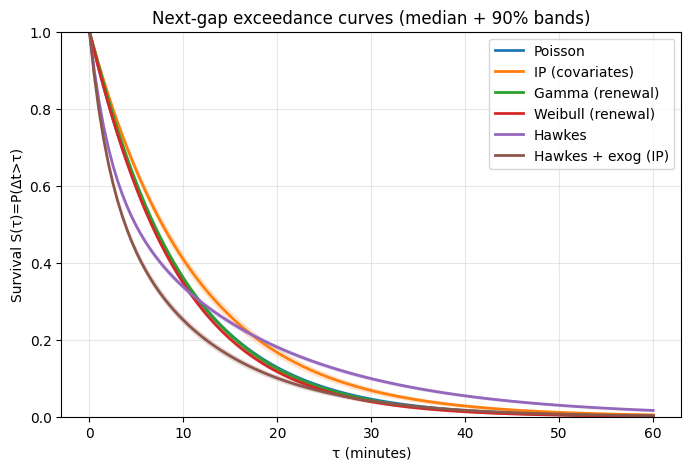

In [48]:
S_p,  b_p  = S_poisson(id_pois, taus)
S_ip_,b_ip = S_ip(id_ip, X_future, taus)
S_g,  b_g  = S_gamma(id_gamma, taus)
S_w,  b_w  = S_weibull(id_weib, taus)
S_h,  b_h  = S_hawkes(id_hawkes, times, taus)
S_hx, b_hx = S_hawkes_exo(id_hawkes, id_ip, X_future, times, taus)

plt.figure(figsize=(8,5))
def band(x, band, label, color, lw=2, alpha=0.15):
    m5,m50,m95 = band
    plt.fill_between(x, m5, m95, alpha=alpha, color=color)
    plt.plot(x, m50, color=color, lw=lw, label=label)

band(taus/60, b_p,  "Poisson",          "tab:blue")
band(taus/60, b_ip, "IP (covariates)",  "tab:orange")
band(taus/60, b_g,  "Gamma (renewal)",  "tab:green")
band(taus/60, b_w,  "Weibull (renewal)","tab:red")
band(taus/60, b_h,  "Hawkes",           "tab:purple")
band(taus/60, b_hx, "Hawkes + exog (IP)","tab:brown")

plt.xlabel("τ (minutes)"); plt.ylabel("Survival S(τ)=P(Δt>τ)")
plt.ylim(0,1); plt.grid(alpha=0.3); plt.legend()
plt.title("Next-gap exceedance curves (median + 90% bands)")
plt.savefig(OUT/"gap_survival.png", dpi=160)
plt.show()


In [49]:
p_vec = np.array([0.3, 0.2, 0.1, 0.05])  # tail probs

def RL_from_grid(taus, S_draws, p_vec):
    """
    taus: 1D array of thresholds (seconds), length M
    S_draws: array of survival draws, shape (N, M), decreasing in taus
    p_vec: 1D array of tail probabilities to invert, e.g. [0.3, 0.2, 0.1, 0.05]
    Returns: (RL, med, lo, hi)
      RL  : (N, len(p_vec)) return levels per draw
      med : median across draws
      lo  : 5th percentile
      hi  : 95th percentile
    """
    taus = np.asarray(taus, float)
    S    = np.asarray(S_draws, float)

    # Ensure taus increasing and S aligned
    order = np.argsort(taus)
    taus  = taus[order]
    S     = S[:, order]

    # Enforce monotone ↓ in taus to avoid wiggles from MC noise
    S = np.minimum.accumulate(S, axis=1)

    # Invert S(τ)=p per draw by interpolating on reversed arrays
    taus_rev = taus[::-1]   # increasing in S
    S_rev    = S[:, ::-1]   # for each draw, xp=S_rev[i] is increasing

    def invert_one_p(p):
        # Row-wise 1D interpolation
        return np.array([np.interp(p, S_rev[i], taus_rev) for i in range(S_rev.shape[0])])

    RL_cols = [invert_one_p(float(p)) for p in np.asarray(p_vec, float)]
    RL  = np.column_stack(RL_cols)          # (N, len(p_vec))
    med = np.median(RL, axis=0)
    lo  = np.percentile(RL, 5,  axis=0)
    hi  = np.percentile(RL, 95, axis=0)
    return RL, med, lo, hi
    
# Compute per model
RL_p,  med_p,  lo_p,  hi_p  = RL_from_grid(taus, S_p,  p_vec)
RL_ip, med_ip, lo_ip, hi_ip = RL_from_grid(taus, S_ip_,p_vec)
RL_g,  med_g,  lo_g,  hi_g  = RL_from_grid(taus, S_g,  p_vec)
RL_w,  med_w,  lo_w,  hi_w  = RL_from_grid(taus, S_w,  p_vec)
RL_h,  med_h,  lo_h,  hi_h  = RL_from_grid(taus, S_h,  p_vec)
RL_hx, med_hx, lo_hx, hi_hx = RL_from_grid(taus, S_hx, p_vec)

def pretty_rl(name, med, lo, hi, p_vec):
    print(name)
    for p, m, l, h in zip(p_vec, med, lo, hi):
        print(f"  p={p:>5.2f}: RL={m:6.1f}s  (90% [{l:6.1f}, {h:6.1f}] s)  ≈ {m/60:4.2f} min")
    print()

pretty_rl("Poisson",           med_p,  lo_p,  hi_p,  p_vec)
pretty_rl("IP (covariates)",   med_ip, lo_ip, hi_ip, p_vec)
pretty_rl("Gamma",             med_g,  lo_g,  hi_g,  p_vec)
pretty_rl("Weibull",           med_w,  lo_w,  hi_w,  p_vec)
pretty_rl("Hawkes",            med_h,  lo_h,  hi_h,  p_vec)
pretty_rl("Hawkes + exog (IP)",med_hx, lo_hx, hi_hx, p_vec)


Poisson
  p= 0.30: RL= 702.2s  (90% [ 692.5,  711.3] s)  ≈ 11.70 min
  p= 0.20: RL= 938.6s  (90% [ 925.8,  950.9] s)  ≈ 15.64 min
  p= 0.10: RL=1342.7s  (90% [1324.5, 1360.3] s)  ≈ 22.38 min
  p= 0.05: RL=1746.8s  (90% [1723.2, 1769.6] s)  ≈ 29.11 min

IP (covariates)
  p= 0.30: RL= 806.7s  (90% [ 780.1,  833.3] s)  ≈ 13.44 min
  p= 0.20: RL=1078.3s  (90% [1043.0, 1113.8] s)  ≈ 17.97 min
  p= 0.10: RL=1542.8s  (90% [1492.1, 1593.5] s)  ≈ 25.71 min
  p= 0.05: RL=2007.1s  (90% [1941.2, 2073.1] s)  ≈ 33.45 min

Gamma
  p= 0.30: RL= 704.1s  (90% [ 694.8,  713.5] s)  ≈ 11.73 min
  p= 0.20: RL= 934.0s  (90% [ 922.2,  946.7] s)  ≈ 15.57 min
  p= 0.10: RL=1325.5s  (90% [1307.9, 1343.8] s)  ≈ 22.09 min
  p= 0.05: RL=1715.3s  (90% [1691.7, 1740.1] s)  ≈ 28.59 min

Weibull
  p= 0.30: RL= 680.1s  (90% [ 671.3,  688.8] s)  ≈ 11.33 min
  p= 0.20: RL= 904.2s  (90% [ 893.0,  915.8] s)  ≈ 15.07 min
  p= 0.10: RL=1285.4s  (90% [1268.8, 1303.0] s)  ≈ 21.42 min
  p= 0.05: RL=1664.7s  (90% [1641.8, 1689.0]

In [50]:


# Build three covariate scenarios from your design matrix X (standardized features)
X_q25 = np.nanpercentile(X, 25, axis=0)
X_q50 = np.nanpercentile(X, 50, axis=0)  # median
X_q75 = np.nanpercentile(X, 75, axis=0)

S_hx_25, bands_25 = S_hawkes_exo(id_hawkes, id_ip, X_q25, times_data, taus)
S_hx_50, bands_50 = S_hawkes_exo(id_hawkes, id_ip, X_q50, times_data, taus)
S_hx_75, bands_75 = S_hawkes_exo(id_hawkes, id_ip, X_q75, times_data, taus)

# Turn into return levels at p = [0.3, 0.2, 0.1, 0.05]
p_vec = np.array([0.3, 0.2, 0.1, 0.05])
RL_25, med_25, lo_25, hi_25 = RL_from_grid(taus, S_hx_25, p_vec)
RL_50, med_50, lo_50, hi_50 = RL_from_grid(taus, S_hx_50, p_vec)
RL_75, med_75, lo_75, hi_75 = RL_from_grid(taus, S_hx_75, p_vec)

def show_rl(label, med, lo, hi):
    print(label)
    for p, m, l, h in zip(p_vec, med, lo, hi):
        print(f"  p={p:>4.2f}: RL={m:6.1f}s  (90%[{l:6.1f},{h:6.1f}])  ≈ {m/60:4.2f} min")
    print()

show_rl("Hawkes+exog @ low covars (Q25)", med_25, lo_25, hi_25)
show_rl("Hawkes+exog @ median covars",    med_50, lo_50, hi_50)
show_rl("Hawkes+exog @ high covars (Q75)",med_75, lo_75, hi_75)

Hawkes+exog @ low covars (Q25)
  p=0.30: RL= 398.9s  (90%[ 388.1, 410.2])  ≈ 6.65 min
  p=0.20: RL= 591.0s  (90%[ 574.2, 608.2])  ≈ 9.85 min
  p=0.10: RL= 945.2s  (90%[ 919.6, 971.6])  ≈ 15.75 min
  p=0.05: RL=1308.2s  (90%[1273.5,1342.9])  ≈ 21.80 min

Hawkes+exog @ median covars
  p=0.30: RL= 436.1s  (90%[ 426.4, 445.9])  ≈ 7.27 min
  p=0.20: RL= 651.9s  (90%[ 637.7, 666.3])  ≈ 10.87 min
  p=0.10: RL=1047.5s  (90%[1027.8,1067.6])  ≈ 17.46 min
  p=0.05: RL=1450.9s  (90%[1426.0,1476.0])  ≈ 24.18 min

Hawkes+exog @ high covars (Q75)
  p=0.30: RL= 466.8s  (90%[ 454.6, 479.5])  ≈ 7.78 min
  p=0.20: RL= 702.7s  (90%[ 684.3, 721.7])  ≈ 11.71 min
  p=0.10: RL=1132.9s  (90%[1105.6,1161.0])  ≈ 18.88 min
  p=0.05: RL=1569.8s  (90%[1534.0,1606.5])  ≈ 26.16 min



In [51]:
# --- imports
import numpy as np
import arviz as az
import xarray as xr

def ensure_ll(idata, varname="interval"):
    # If already present, leave it
    if hasattr(idata, "log_likelihood") and varname in idata.log_likelihood.data_vars:
        return idata
    # If log_likelihood exists but under a different name, alias it
    if hasattr(idata, "log_likelihood") and len(idata.log_likelihood.data_vars):
        first = list(idata.log_likelihood.data_vars)[0]
        idata.log_likelihood = idata.log_likelihood.assign({varname: idata.log_likelihood[first]})
        return idata
    # If you stored a posterior deterministic, promote it
    if hasattr(idata, "posterior") and "ll_interval" in idata.posterior.data_vars:
        ll = idata.posterior["ll_interval"]
        idata.add_groups({"log_likelihood": xr.Dataset({varname: ll})})
        return idata
    raise ValueError("Could not find a log-likelihood to alias as 'interval'.")

def _obs_dim(ll_da):
    # return the non (chain,draw) dimension name
    for d in ll_da.dims:
        if d not in ("chain", "draw"):
            return d
    raise ValueError("Could not find observation dimension in log_likelihood")

def _align_dt_to_ll(dt_full, L):
    dt_full = np.asarray(dt_full, float)
    if dt_full.size == L:
        return dt_full
    if dt_full.size == L + 1:     # common off-by-one when dt was built from times
        return dt_full[-L:]       # drop leading element
    if dt_full.size > L:
        return dt_full[:L]        # trim (last resort)
    raise ValueError(f"dt length {dt_full.size} < loglik length {L}")

def tail_slice_idata(idata, tau, dt_full, varname="interval"):
    ll = idata.log_likelihood[varname]
    od = _obs_dim(ll)
    L  = ll.sizes[od]
    dt = _align_dt_to_ll(dt_full, L)
    idx = np.where(dt > float(tau))[0]           # integer positions
    ll_tail = ll.isel({od: idx})                 # <-- positional indexing
    id_tail = idata.copy()
    id_tail.log_likelihood = id_tail.log_likelihood.assign({varname: ll_tail})
    return id_tail

import numpy as np
import xarray as xr
import arviz as az

def ensure_ll(idata, varname="interval"):
    """Return a copy whose log_likelihood group has a single var `varname`
    with obs-dim named 'interval'."""
    id2 = idata.copy()

    # Case A: already has desired var
    if hasattr(id2, "log_likelihood") and varname in id2.log_likelihood.data_vars:
        # normalize obs dim name to 'interval'
        ll = id2.log_likelihood[varname]
        obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else ("interval" if "interval" in ll.dims else ll.dims[-1])
        if obs_dim != "interval":
            ll = ll.rename({obs_dim: "interval"})
            id2.log_likelihood = xr.Dataset({varname: ll})
        return id2

    # Case B: has some loglik var already → take first and normalize
    if hasattr(id2, "log_likelihood") and len(id2.log_likelihood.data_vars) > 0:
        first = next(iter(id2.log_likelihood.data_vars))
        ll = id2.log_likelihood[first]
        obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else ("interval" if "interval" in ll.dims else ll.dims[-1])
        ll = ll.rename({obs_dim: "interval"})
        id2.log_likelihood = xr.Dataset({varname: ll})
        return id2

    # Case C: promote posterior deterministic 'll_interval'
    if hasattr(id2, "posterior") and "ll_interval" in id2.posterior.data_vars:
        ll = id2.posterior["ll_interval"]
        obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else ("interval" if "interval" in ll.dims else ll.dims[-1])
        ll = ll.rename({obs_dim: "interval"})
        id2.log_likelihood = xr.Dataset({varname: ll})
        return id2

    raise ValueError("No log-likelihood found to normalize.")

def _align_dt_with_ll(dt_full, ll):
    """Return a dt vector whose length matches the ll obs length."""
    dt_vec = np.asarray(dt_full, float)
    obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else "interval"
    n = ll.sizes[obs_dim]
    if dt_vec.size == n:
        return dt_vec
    if dt_vec.size == n + 1:
        # your common pattern: dt was built including a leading gap
        return dt_vec[1:]
    raise ValueError(f"dt length {dt_vec.size} not compatible with ll length {n}")

def tail_slice_idata(idata, tau, dt_full, varname="interval"):
    """Return a copy whose log_likelihood is restricted to Δt > tau."""
    # 1) get/normalize the loglik var
    if not hasattr(idata, "log_likelihood"):
        raise ValueError("idata has no log_likelihood group")
    ll = idata.log_likelihood[varname] if varname in idata.log_likelihood.data_vars else next(iter(idata.log_likelihood.data_vars))
    if isinstance(ll, str):  # if next(iter(...)) returned name
        ll = idata.log_likelihood[ll]

    # normalize obs dim name
    obs_dim = "interval_dim_0" if "interval_dim_0" in ll.dims else ("interval" if "interval" in ll.dims else ll.dims[-1])

    # 2) build tail mask aligned to ll’s obs length
    dt_use = _align_dt_with_ll(dt_full, ll)
    idx = np.where(dt_use > float(tau))[0]

    # 3) slice and rename to 'interval'
    ll_tail = ll.isel({obs_dim: idx}).rename({obs_dim: "interval"})

    # 4) replace the entire log_likelihood dataset with the tail only
    id_tail = idata.copy()
    id_tail.log_likelihood = xr.Dataset({varname: ll_tail})
    return id_tail


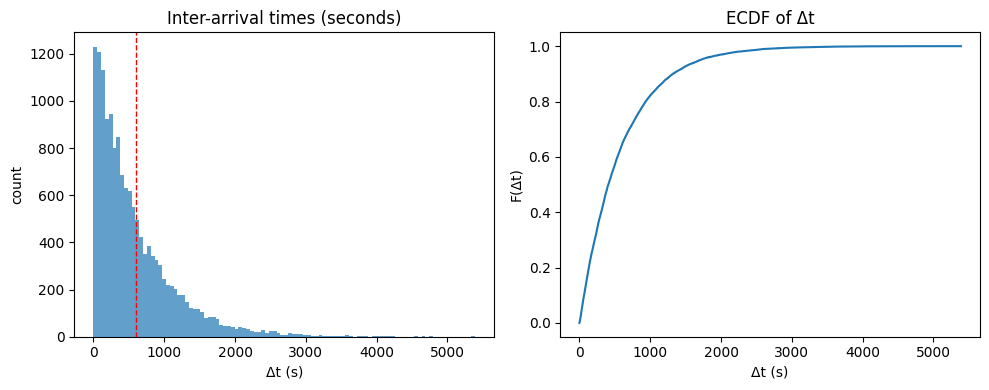

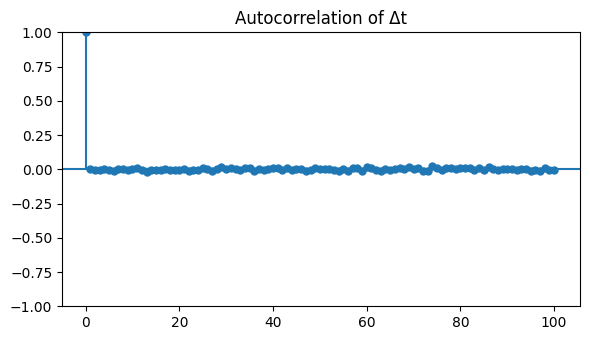

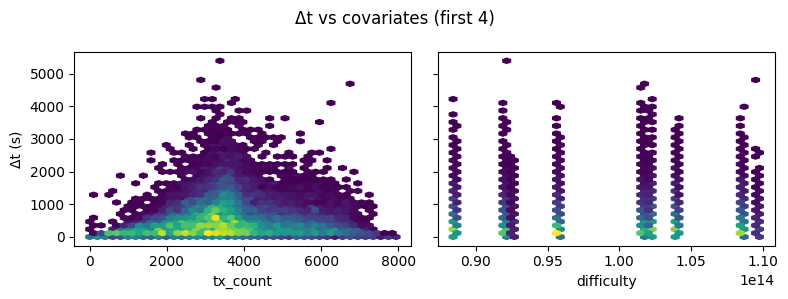

In [52]:
import statsmodels.api as sm
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(dt, bins=100, alpha=0.7)
ax[0].axvline(600, color='r', ls='--', lw=1); ax[0].set_title("Inter-arrival times (seconds)")
ax[0].set_xlabel("Δt (s)"); ax[0].set_ylabel("count")

x = np.sort(dt); y = np.arange(1, len(x)+1)/len(x)
ax[1].plot(x, y); ax[1].set_title("ECDF of Δt"); ax[1].set_xlabel("Δt (s)"); ax[1].set_ylabel("F(Δt)")
fig.tight_layout(); fig.savefig(OUT/"fig_data_hist_ecdf.png", dpi=160)

# Autocorrelation of gaps
fig = plt.figure(figsize=(6,3.5))
sm.graphics.tsa.plot_acf(dt, lags=100, ax=plt.gca())
plt.title("Autocorrelation of Δt"); plt.tight_layout(); plt.savefig(OUT/"fig_acf.png", dpi=160)

# Covariate scatter (if df exists)
if "df" in globals():
    cols = [c for c in ("tx_count","difficulty") if c in df.columns]
    k = min(4, len(cols))
    if k:
        fig, axes = plt.subplots(1,k, figsize=(4*k,3), sharey=True)
        for j,c in enumerate(cols[:k]):
            axes[j].hexbin(df[c].values, dt, gridsize=40, mincnt=1)
            axes[j].set_xlabel(c)
        axes[0].set_ylabel("Δt (s)")
        plt.suptitle("Δt vs covariates (first 4)"); plt.tight_layout()
        plt.savefig(OUT/"fig_covariates_hex.png", dpi=160)

In [53]:
# normalize all idatas first (no in-place assign that tries to align)
"""packs = {}
for nm in ("id_pois","id_ip","id_gamma","id_weib","id_hawkes"):
    if nm in globals():
        packs[nm[3:]] = ensure_ll(globals()[nm], varname="interval")"""



'packs = {}\nfor nm in ("id_pois","id_ip","id_gamma","id_weib","id_hawkes"):\n    if nm in globals():\n        packs[nm[3:]] = ensure_ll(globals()[nm], varname="interval")'

In [54]:
import os, numpy as np, arviz as az

# tame threads (optional but helps memory spikes)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

def thin_ll(idata, varname="interval", draws_max=800):
    ll = az.stats.stats_utils.get_log_likelihood(idata, var_name=varname)  # (chain, draw, obs)
    if "draw" in ll.dims and ll.sizes["draw"] > draws_max:
        step = int(np.ceil(ll.sizes["draw"] / draws_max))
        ll = ll.isel(draw=slice(0, None, step))
    ll = ll.astype(np.float32)
    return az.from_dict(log_likelihood={varname: ll})

def loo_one(idata, varname="interval"):
    mini = thin_ll(idata, varname=varname)
    # <- key change: provide reff explicitly so posterior is not required
    return az.loo(mini, var_name=varname, pointwise=True, reff=1.0)

loos = {}
for name, idata in {"pois": id_pois, "ip": id_ip, "gamma": id_gamma, "weib": id_weib, "hawkes": id_hawkes}.items():
    if idata is None:
        continue
    loos[name] = loo_one(idata, varname="interval")

cmp_full = az.compare(loos, ic="loo", method="stacking")
display(cmp_full)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hawkes,0,-104990.721501,1.275160,0.000000,1.000000e+00,152.941265,0.000000,False,log
ip,1,-110481.524734,2.947440,5490.803233,2.302858e-08,120.798444,68.736565,False,log
gamma,2,-110508.944887,1.978485,5518.223386,6.263826e-08,120.078901,72.487665,False,log
pois,3,-110519.981266,0.964571,5529.259765,1.319581e-18,119.915033,68.901477,False,log
weib,4,-110522.400189,1.901553,5531.678688,0.000000e+00,124.490815,70.151187,False,log


Text(0.5, 0, 'elpd_loo (log)')

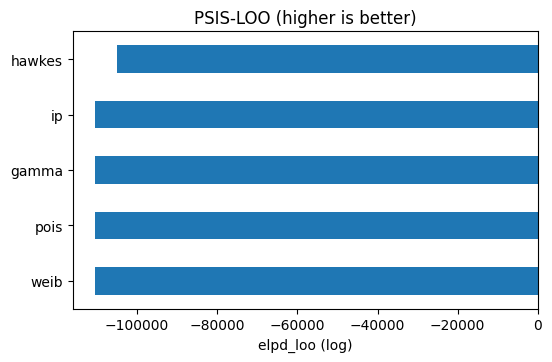

In [55]:
#display(cmp_full)
ax = cmp_full.sort_values("elpd_loo")["elpd_loo"].plot.barh(figsize=(6,3.6))
ax.set_title("PSIS-LOO (higher is better)"); ax.set_xlabel("elpd_loo (log)")

[skip] id_gamma: Concatenating overlapping groups is not supported unless `dim` is defined. Valid dimensions are `chain` and `draw`. Alternatively, use extend to combine InferenceData with overlapping groups
[skip] id_weib: Concatenating overlapping groups is not supported unless `dim` is defined. Valid dimensions are `chain` and `draw`. Alternatively, use extend to combine InferenceData with overlapping groups


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hawkes,0,-104990.721501,1.275160,0.000000,1.000000e+00,152.941265,0.000000,False,log
ip,1,-110481.524734,2.947440,5490.803233,6.114429e-08,120.798444,68.736565,False,log
pois,2,-110519.981266,0.964571,5529.259765,0.000000e+00,119.915033,68.901477,False,log


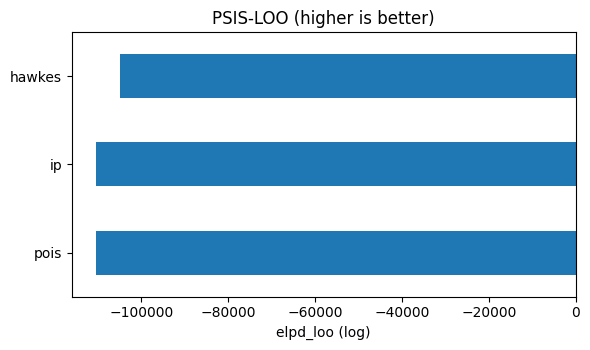

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hawkes,0,-44511.298579,0.508449,0.000000,0.749175,52.490614,0.000000,False,log
pois,1,-44828.497063,0.705630,317.198484,0.093650,70.810181,36.985705,False,log
ip,2,-44836.621586,1.773612,325.323007,0.157175,71.134516,37.472334,False,log


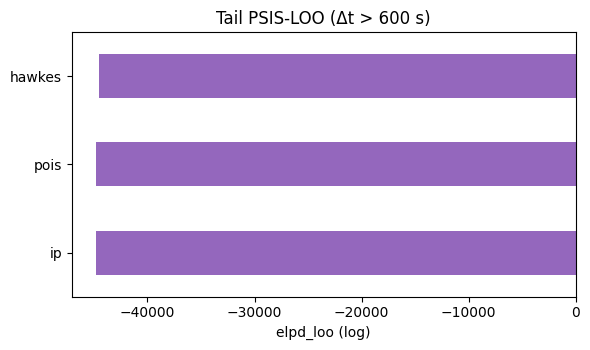

In [74]:
# keep BLAS forks tame (helps on WSL/low RAM)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

def ensure_ll(idata, varname="interval"):
    """Make sure idata.log_likelihood[varname] exists.
       If it already exists, do nothing. If only 'y' exists, alias it.
       If you stored ll as posterior deterministic 'll_interval', promote it."""
    if not hasattr(idata, "log_likelihood"):
        # Try to promote a posterior deterministic
        if hasattr(idata, "posterior") and ("ll_interval" in idata.posterior.data_vars):
            ll = idata.posterior["ll_interval"]
            idata = az.concat(
                idata,
                az.from_dict(log_likelihood={varname: ll}),
                copy=True
            )
            return idata
        raise ValueError("No log_likelihood group found and no 'll_interval' to promote.")

    if varname in idata.log_likelihood.data_vars:
        return idata

    # fallbacks: take the first ll var and alias it
    ll_keys = list(idata.log_likelihood.data_vars)
    if "y" in ll_keys:
        base = idata.log_likelihood["y"]
    else:
        base = idata.log_likelihood[ll_keys[0]]
    # concat instead of add_groups to avoid 'group exists' and coord merge issues
    idata = az.concat(idata, az.from_dict(log_likelihood={varname: base}), copy=True)
    return idata

def _obs_dim_name(ll_da, varname="interval"):
    """Return the name of the observation dimension inside a ll DataArray."""
    # typical: ('chain','draw','interval') or ('chain','draw','interval_dim_0')
    if varname in ll_da.dims:
        return varname
    # fall back to last dim
    return ll_da.dims[-1]

def tail_slice_idata(idata, tau, dt_full, varname="interval"):
    """Return a copy of idata with log_likelihood[varname] subset to dt > tau."""
    idata = ensure_ll(idata, varname=varname)
    ll = idata.log_likelihood[varname]
    od = _obs_dim_name(ll, varname=varname)

    # align dt length to obs dimension length if off by 1 (rare)
    n_obs = ll.sizes[od]
    if len(dt_full) != n_obs:
        m = min(len(dt_full), n_obs)
        dt_use = np.asarray(dt_full[:m], float)
        ll = ll.isel({od: slice(0, m)})
    else:
        dt_use = np.asarray(dt_full, float)

    idx = np.where(dt_use > float(tau))[0]
    ll_tail = ll.isel({od: idx})

    # Build a new minimal idata carrying only this sliced ll (keeps dims/coords intact)
    return az.from_dict(log_likelihood={varname: ll_tail})

def thin_ll(idata, varname="interval", draws_max=800):
    """Return a tiny InferenceData with only log_likelihood[varname] and ≤draws_max draws (float32)."""
    ll = az.stats.stats_utils.get_log_likelihood(idata, var_name=varname)
    if "draw" in ll.dims and ll.sizes["draw"] > draws_max:
        step = int(np.ceil(ll.sizes["draw"] / draws_max))
        ll = ll.isel(draw=slice(0, None, step))
    ll = ll.astype(np.float32)
    return az.from_dict(log_likelihood={varname: ll})

def loo_one(idata, varname="interval"):
    """Compute LOO on a thinned LL-only idata. Provide reff to avoid needing posterior."""
    mini = thin_ll(idata, varname=varname)
    return az.loo(mini, var_name=varname, pointwise=True, reff=1.0)

# --- 1) BUILD packs from whatever models exist in the namespace ---------------
packs = {}
for nm in ("id_pois", "id_ip", "id_gamma", "id_weib", "id_hawkes"):
    if nm in globals() and (globals()[nm] is not None):
        try:
            packs[nm[3:]] = ensure_ll(globals()[nm], varname="interval")
        except Exception as e:
            print(f"[skip] {nm}: {e}")

if not packs:
    raise RuntimeError("No models found to compare. Define any of id_pois/id_ip/id_gamma/id_weib/id_hawkes.")

# --- 2) FULL-SAMPLE PSIS-LOO (memory-safe) -----------------------------------
loos_full = {name: loo_one(idt, varname="interval") for name, idt in packs.items()}
cmp_full = az.compare(loos_full, ic="loo", method="stacking")
display(cmp_full)

ax = cmp_full.sort_values("elpd_loo")["elpd_loo"].plot.barh(figsize=(6,3.6))
ax.set_title("PSIS-LOO (higher is better)"); ax.set_xlabel("elpd_loo (log)"); plt.tight_layout(); plt.show()

# --- 3) TAIL-ONLY (Δt > τ) PSIS-LOO ------------------------------------------
tau = 600.0
if "dt" not in globals():
    raise RuntimeError("Expected a 1D numpy array 'dt' with inter-arrival times to define the tail mask.")

packs_tail = {}
for name, idt in packs.items():
    try:
        id_tail = tail_slice_idata(idt, tau, dt, varname="interval")
        # skip blank tails (e.g., no gaps > tau for some toy data)
        if id_tail.log_likelihood["interval"].sizes[_obs_dim_name(id_tail.log_likelihood["interval"], "interval")] == 0:
            print(f"[tail] {name}: no observations with Δt > {tau}")
            continue
        packs_tail[name] = id_tail
    except Exception as e:
        print(f"[skip tail] {name}: {e}")

if packs_tail:
    loos_tail = {name: loo_one(idt, varname="interval") for name, idt in packs_tail.items()}
    cmp_tail = az.compare(loos_tail, ic="loo", method="stacking")
    display(cmp_tail)

    ax = cmp_tail.sort_values("elpd_loo")["elpd_loo"].plot.barh(figsize=(6,3.6), color="tab:purple")
    ax.set_title(f"Tail PSIS-LOO (Δt > {int(tau)} s)"); ax.set_xlabel("elpd_loo (log)")
    plt.tight_layout(); plt.show()
else:
    print(f"No tail observations (Δt > {tau}) available across models.")

In [75]:
import numpy as np
from scipy.special import gammaincc  # for Gamma survival

# ---------- helpers ----------
def _flatten(da):
    """Flatten (chain, draw, ...) to (ndraws, ...). Accepts xarray DataArray or np.ndarray."""
    arr = np.asarray(da)
    if arr.ndim >= 2:
        return arr.reshape(arr.shape[0] * arr.shape[1], *arr.shape[2:])
    return arr

def _get_first_posterior(idata, names):
    """Return idata.posterior[var] for the first name that exists."""
    for n in names:
        if n in idata.posterior.data_vars:
            return idata.posterior[n]
    raise KeyError(f"None of {names} found in posterior vars: {list(idata.posterior.data_vars)}")

def bands(S, axis=0, qs=(5, 50, 95)):
    """Percentile bands along axis for an array of draws."""
    return tuple(np.percentile(S, q, axis=axis) for q in qs)

# ---------- survival functions S(τ) = P(Δt > τ) per model ----------
def S_poisson(id_pois, taus):
    mu = _flatten(_get_first_posterior(id_pois, ("mu", "lam", "lambda")))[:, None]  # (n,1)
    t  = np.asarray(taus, float)[None, :]                                           # (1,T)
    return np.exp(-mu * t)                                                          # (n,T)

def S_gamma(id_gamma, taus):
    # PyMC Gamma(alpha=k, beta=rate): survival = Q(k, rate*τ) = gammaincc(k, rate*τ)
    k    = _flatten(_get_first_posterior(id_gamma, ("k", "alpha", "shape")))[:, None]
    rate = _flatten(_get_first_posterior(id_gamma, ("rate", "beta")))[:, None]
    t    = np.asarray(taus, float)[None, :]
    return gammaincc(k, rate * t)

def S_weibull(id_weib, taus):
    # PyMC Weibull(alpha=shape k, beta=scale λ): survival = exp(-(τ/λ)^k)
    k   = _flatten(_get_first_posterior(id_weib, ("k", "alpha", "shape")))[:, None]
    lam = _flatten(_get_first_posterior(id_weib, ("lam", "lambda", "beta", "scale")))[:, None]
    t   = np.asarray(taus, float)[None, :]
    return np.exp(-np.power(np.clip(t / np.maximum(lam, 1e-12), 0.0, 1e12), k))

def S_ip(id_ip, X_future_row, taus):
    """Inhomogeneous Poisson with log λ = β0 + x·b (your IP model).
       Tries to find either vector 'b' or named slopes like b_diff, b_tx, ..."""
    x = np.asarray(X_future_row, float)
    x = np.where(np.isfinite(x), x, 0.0)
    p = x.shape[0]

    post = id_ip.posterior

    # intercept
    beta0 = _flatten(post["beta0"]) if "beta0" in post.data_vars else None
    if beta0 is None:
        beta0 = np.zeros(post.sizes["chain"] * post.sizes["draw"], dtype=float)

    # coefficients
    if "b" in post.data_vars:
        b = _flatten(post["b"])                           # (n, p_expected)
        if b.shape[1] != p:
            raise ValueError(f"Posterior 'b' has p={b.shape[1]}, but X has p={p}.")
    else:
        # fall back to individual coefficient names used earlier
        cand = [n for n in ("b_diff","b_tx") if n in post.data_vars]
        if not cand:
            raise RuntimeError("Could not find a coefficient vector or named slopes in id_ip.posterior")
        # use as many as available, align to x length
        cand = cand[:p]
        B_cols = [_flatten(post[n]) for n in cand]
        # stack columns to (n, p_used), and trim x accordingly
        b = np.vstack(B_cols).T
        x = x[: b.shape[1]]

    # align lengths (rare mismatch across vars)
    nd = min(beta0.shape[0], b.shape[0])
    beta0 = beta0[:nd]
    b     = b[:nd, :]

    lin = beta0 + b @ x                 # (nd,)
    lam = np.exp(np.clip(lin, -40, 40))[:, None]
    t   = np.asarray(taus, float)[None, :]
    return np.exp(-lam * t)             # (nd, T)

# (If you also call S_hawkes / S_hawkes_exo later, keep your existing versions.)


In [76]:
import numpy as np

def _flat_da(da):
    """Flatten (chain, draw, ...) -> (ndraws, ...)"""
    arr = np.asarray(da)
    if arr.ndim < 2:
        raise ValueError(f"Expected at least (chain, draw), got shape {arr.shape}")
    return arr.reshape(arr.shape[0]*arr.shape[1], *arr.shape[2:])

def detect_ip_coef(id_ip, x_future, feat_names=None, strict=True):
    """
    Extract (intercept, coefficient matrix) from an IP InferenceData.

    Parameters
    ----------
    id_ip : arviz.InferenceData
        Posterior containing either:
          - vector 'b' with dim 'feat'  (chain, draw, feat)
          - or scalar slopes like 'b_diff', 'b_tx', ... each (chain, draw)
        Optional intercept variable names: 'beta0', 'intercept', 'const', 'b0'.
    x_future : 1D array-like
        Feature vector you intend to use (its length defines p).
    feat_names : list[str] or None
        Preferred order of scalar slope variable names (e.g.,
        ['b_diff','b_tx','b_size','b_weight','b_input','b_fees']).
        If None, we’ll try to auto-detect any 'b_*' present.
    strict : bool
        If True, require that we can build exactly p coefficients.
        If False, we will align to the *intersection* of available coefficients
        and the first p features of x_future.

    Returns
    -------
    beta0_draws : (ndraws,)
    B_draws     : (ndraws, p)
        Coefficient draws aligned to the order of x_future.
        If only a subset is available and strict=False, missing slots are zeros.
    used_names  : list[str]
        Names used for the p coefficients (for auditing).
    """
    post  = id_ip.posterior
    names = set(post.data_vars)

    x = np.asarray(x_future, float)
    p = x.size

    # 1) Intercept
    for nm in ("beta0","intercept","const","b0","alpha0"):
        if nm in names:
            beta0_draws = _flat_da(post[nm]).astype(float)
            break
    else:
        beta0_draws = np.zeros(_flat_da(next(iter(post.data_vars.values()))).shape[0], dtype=float)

    # 2) Coefficients
    # Case A: vector 'b' with 'feat' dim
    if "b" in names and "feat" in post["b"].dims:
        b_da = post["b"].transpose("chain","draw","feat")
        B = _flat_da(b_da).astype(float)  # (ndraws, feat)
        feat_in_model = B.shape[1]
        if feat_in_model == p:
            used = [f"b[{j}]" for j in range(p)]
            return beta0_draws, B, used
        elif feat_in_model < p:
            # pad with zeros for missing trailing features
            pad = np.zeros((B.shape[0], p - feat_in_model), dtype=float)
            used = [f"b[{j}]" for j in range(feat_in_model)] + [None]*(p - feat_in_model)
            return beta0_draws, np.hstack([B, pad]), used
        else:
            # model has more features than x_future: take first p
            used = [f"b[{j}]" for j in range(p)]
            return beta0_draws, B[:, :p], used

    # Case B: scalar slopes (e.g., b_diff, b_tx, ...)
    # If user gave an order, respect it; otherwise auto-detect any b_* names
    if feat_names is None:
        feat_names = sorted([nm for nm in names if nm.startswith("b_") or nm in ("b_diff","b_tx")])

    picked = [nm for nm in feat_names if nm in names]
    if strict and len(picked) != p:
        raise RuntimeError(
            f"Could not find exactly {p} coefficient(s) in posterior. "
            f"Available: {picked} ; expected order: {feat_names}"
        )

    # Build B with zeros then fill available columns in order
    ndraws = beta0_draws.shape[0]
    B = np.zeros((ndraws, p), dtype=float)
    used = [None]*p
    # use min(p, len(picked)) to avoid index errors if strict=False
    for j, nm in enumerate(picked[:p]):
        B[:, j] = _flat_da(post[nm]).astype(float)
        used[j] = nm

    return beta0_draws, B, used

In [77]:
import numpy as np

def hawkes_s0(times, beta):
    """
    Compute S0 = 1 + sum_{i=1}^{N-1} exp(-beta (t_N - t_i))
    for a strictly increasing array of event times.
    """
    times = np.asarray(times, float)
    tN = times[-1]
    gaps = tN - times[:-1]
    return 1.0 + np.exp(-beta * gaps).sum()

def _hawkes_nextgap_draw(mu, alpha, beta, s0, rng=None):
    """
    One draw of the next inter-arrival time for an exponential Hawkes after t_N.

    Parameters
    ----------
    mu, alpha, beta : floats (mu>0, alpha>=0, beta>0)
    s0              : float, >= 1 (the 'cluster state' right after t_N; see hawkes_s0)
    rng             : np.random.Generator or None

    Returns
    -------
    u : float >= 0 (np.inf possible if both components are infinite, but with mu>0 this won't happen)
    """
    if rng is None:
        rng = np.random.default_rng()

    # immigrant component ~ Exp(mu)
    t_imm = rng.exponential(1.0 / max(mu, 1e-15))

    # offspring component via inversion
    lam = alpha * s0
    if lam <= 0.0:
        t_off = np.inf
    else:
        # E ~ Exp(1)
        E = rng.exponential(1.0)
        thresh = lam / beta
        if E >= thresh:
            t_off = np.inf
        else:
            val = 1.0 - (beta / lam) * E   # in (0,1]
            val = min(max(val, 1e-300), 1.0)
            t_off = -np.log(val) / beta

    return min(t_imm, t_off)

def hawkes_nextgap_exceed_from_params(mu_draws, alpha_draws, beta_draws, s0_draws, taus, n_sims_per_draw=50, seed=123):
    """
    Monte Carlo estimate of S(τ)=P(Δt>τ) over posterior draws.

    Inputs are arrays of equal length n_draws with (mu, alpha, beta, s0) per draw.
    """
    rng = np.random.default_rng(seed)
    taus = np.asarray(taus, float)
    n = len(mu_draws)
    S = np.empty((n, taus.size), float)

    for i in range(n):
        mu = float(mu_draws[i]); alpha = float(alpha_draws[i]); beta = float(beta_draws[i]); s0 = float(s0_draws[i])
        samples = np.array([_hawkes_nextgap_draw(mu, alpha, beta, s0, rng) for _ in range(n_sims_per_draw)])
        # survival at taus
        S[i, :] = (samples[:, None] > taus[None, :]).mean(axis=0)

    return S  # shape (n_draws, len(taus))


In [78]:
X.shape

(15000, 2)

In [79]:

# --- helper: single-step next-gap sampler for Hawkes with exp kernel
def _hawkes_sim_nextgap(mu, alpha, beta, s0, rng=None, tmax=36000.0):
    """
    Simulate the waiting time to the NEXT event given current state s0
    for a Hawkes(mu, alpha, beta) with exp kernel and intensity:
        λ(t) = μ + α * s0 * exp(-β t)   (until next event)
    Ogata thinning restricted to the first arrival.
    """
    if rng is None:
        rng = np.random.default_rng()
    # Upper bound on intensity while waiting: at t=0 it's μ + α s0
    lam_bar = mu + alpha * s0
    if lam_bar <= 0:
        return tmax  # degenerate safety
    t = 0.0
    while t < tmax:
        # propose
        w = rng.exponential(1.0 / lam_bar)
        t += w
        # actual intensity at t
        lam_t = mu + alpha * s0 * np.exp(-beta * t)
        if rng.uniform() * lam_bar <= lam_t:
            return t
        # else reject and continue (lam_bar is still valid upper bound)
    return tmax

In [80]:
# === inputs expected in your environment ===
# - id_ip, id_hawkes, X, times_data, taus, p_vec
# - detect_ip_coef (the draw-extracting version I gave earlier)
assert "id_ip" in globals() and "id_hawkes" in globals() and "X" in globals() and "times_data" in globals()

In [81]:
# 1) Feature quantiles (p columns)
Xq = np.vstack([np.nanpercentile(X, q, axis=0) for q in (25, 50, 75)])  # (3,p)
x_dummy = Xq[0]

In [82]:
# 2) Get IP draws -> baseline μ_exo per draw
#    This returns arrays, not variable names:
#      beta0_draws: (ndraws,)
#      B_draws    : (ndraws, p)
#      used       : list of names for auditing
beta0_draws, B_draws, used = detect_ip_coef(id_ip, x_dummy, strict=False)

In [83]:
# 3) Get Hawkes parameter draws and current state s0 per draw
t = np.asarray(times_data, float)
last = t[-1]
gaps = last - t[:-1]                       # (N-1,)

# flatten helpers
def _flat(da): 
    arr = np.asarray(da)
    return arr.reshape(arr.shape[0]*arr.shape[1], *arr.shape[2:]) if arr.ndim >= 2 else arr

mu_h   = _flat(id_hawkes.posterior[ next(n for n in ("mu",)   if n in id_hawkes.posterior.data_vars) ])
beta_h = _flat(id_hawkes.posterior[ next(n for n in ("beta",) if n in id_hawkes.posterior.data_vars) ])
if "alpha" in id_hawkes.posterior.data_vars:
    alpha_h = _flat(id_hawkes.posterior["alpha"])
else:
    rho     = _flat(id_hawkes.posterior["rho"])
    alpha_h = rho * beta_h

# keep common number of draws with IP arrays
nd = min(beta0_draws.shape[0], B_draws.shape[0], mu_h.shape[0], alpha_h.shape[0], beta_h.shape[0])
beta0_draws = beta0_draws[:nd]
B_draws     = B_draws[:nd, :]
mu_h        = mu_h[:nd]
alpha_h     = alpha_h[:nd]
beta_h      = beta_h[:nd]

# state s0 (per draw) at "now"
# s0 = sum_j exp(-beta * (last - t_j)) = sum over all past events
s0 = np.exp(-np.outer(beta_h, gaps)).sum(axis=1)  # (nd,)

In [84]:
# 4) Function: compute survival grid S(τ) for Hawkes+exog given a feature row
rng = np.random.default_rng(123)

def S_hawkes_exo_row(x_row, taus, sims_per_draw=30):
    x = np.asarray(x_row, float)
    # μ_exo per draw from IP linear predictor
    lin = np.clip(beta0_draws + B_draws @ x, -40, 40)   # (nd,)
    mu_exo = np.exp(lin)                                # (nd,)

    # simulate next-gap per draw, multiple replicates
    nT = len(taus)
    S  = np.zeros((nd, nT), dtype=float)
    for i in range(nd):
        tgaps = np.array([_hawkes_sim_nextgap(mu_exo[i], alpha_h[i], beta_h[i], s0[i], rng=rng) 
                          for _ in range(sims_per_draw)])
        tgaps.sort()
        for j, tau in enumerate(taus):
            S[i, j] = np.mean(tgaps > tau)
    return S

In [85]:
# 5) Build return-level summaries for Q25 / median / Q75 covariates
def _monotone_decreasing(y):
    # make any survival curve monotone ↓ (helps interpolation)
    out = y.copy()
    for k in range(1, out.size):
        if out[k] > out[k-1]:
            out[k] = out[k-1]
    return out

In [86]:
def RL_from_grid(taus, S_draws, p_vec):
    """
    Invert survival curves S(τ) to get return levels RL(p) for each posterior draw.
    taus:    (T,) grid in seconds (increasing)
    S_draws: (N, T) survival per draw (decreasing in τ)
    p_vec:   (P,) tail probabilities (e.g., [0.3, 0.2, 0.1, 0.05])
    Returns dict with samples and 5/50/95% summaries over draws.
    """
    taus = np.asarray(taus, float).ravel()
    Sd   = np.asarray(S_draws, float)
    p_vec = np.asarray(p_vec, float).ravel()

    # enforce monotone ↓ per draw (guards small numerical wiggles)
    Sd = np.apply_along_axis(lambda y: np.minimum.accumulate(y), 1, Sd)

    # optionally ensure the grid starts at (τ=0, S≈1)
    if taus[0] > 0 or not np.allclose(Sd[:, 0], 1.0, atol=1e-6):
        taus_ext = np.concatenate(([0.0], taus))
        Sd_ext   = np.concatenate((np.ones((Sd.shape[0], 1)), Sd), axis=1)
    else:
        taus_ext, Sd_ext = taus, Sd

    # invert S(τ)=p for each draw separately
    RL_list = []
    for p in p_vec:
        # per-draw interpolation (S is decreasing → reverse each row)
        tau_p = np.array([np.interp(p, s[::-1], taus_ext[::-1]) for s in Sd_ext])
        RL_list.append(tau_p)

    RL = np.stack(RL_list, axis=1)  # (N_draws, P)
    return {
        "samples": RL,
        "median":  np.median(RL, axis=0),
        "lo5":     np.percentile(RL, 5, axis=0),
        "hi95":    np.percentile(RL, 95, axis=0),
    }

taus = np.asarray(taus, float)
p_vec = np.asarray(p_vec, float)

labels = ["Q25 covars", "Median covars", "Q75 covars"]
RL_exo = {}
for lab, xrow in zip(labels, Xq):
    Sx = S_hawkes_exo_row(xrow, taus, sims_per_draw=30)
    RL_exo[lab] = RL_from_grid(taus, Sx, p_vec)

In [87]:
# 6) Tabulate
def rl_to_df(name, stats):
    med, lo,hi = stats["median"], stats["lo5"], stats["hi95"]
    return pd.DataFrame({
        "Scenario": name,
        "p": p_vec,
        "RL_sec": med,
        "RL_lo5": lo,
        "RL_hi95": hi,
        "RL_min": med/60
    })

df_exo = pd.concat([rl_to_df(n, s) for n, s in RL_exo.items()], ignore_index=True)
display(df_exo)

Path("tables").mkdir(exist_ok=True)
(Path("tables")/"return_levels_hawkes_exog.tex").write_text(
    df_exo.to_latex(index=False, float_format="%.1f", escape=False,
                    caption="Hawkes + exogenous baseline: return levels across covariate quantiles.",
                    label="tab:hawkes_exog_rl")
)

,Scenario,p,RL_sec,RL_lo5,RL_hi95,RL_min
0,Q25 covars,0.30,525.000000,450.000000,650.0,8.750000
1,Q25 covars,0.20,600.000000,514.285714,900.0,10.000000
2,Q25 covars,0.10,900.000000,578.571429,1200.0,15.000000
3,Q25 covars,0.05,1200.000000,787.500000,1200.0,20.000000
4,Median covars,0.30,525.000000,466.666667,700.0,8.750000
5,Median covars,0.20,600.000000,533.333333,1021.5,10.000000
6,Median covars,0.10,1050.000000,600.000000,1200.0,17.500000
7,Median covars,0.05,1200.000000,850.000000,1200.0,20.000000
8,Q75 covars,0.30,547.826087,466.666667,750.0,9.130435
9,Q75 covars,0.20,700.000000,533.333333,1100.0,11.666667


889

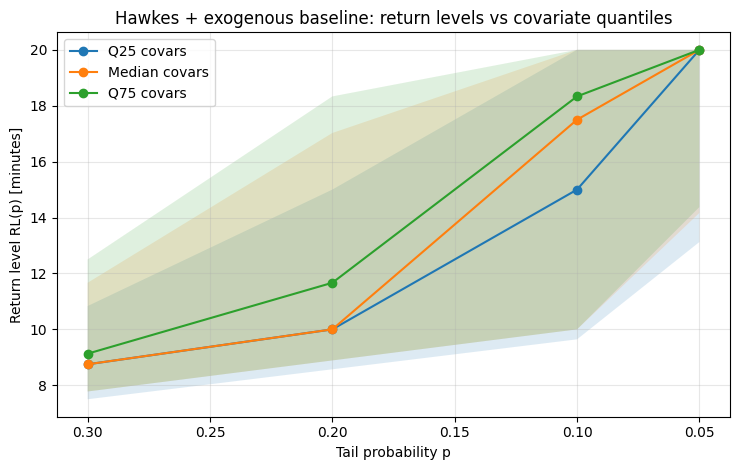

In [88]:
# 7) Plot
plt.figure(figsize=(7.5,4.8))
for lab, st in RL_exo.items():
    m, lo, hi = st["median"]/60, st["lo5"]/60, st["hi95"]/60
    plt.plot(p_vec, m, marker="o", label=lab)
    plt.fill_between(p_vec, lo, hi, alpha=0.15)
plt.gca().invert_xaxis(); plt.grid(alpha=0.3); plt.legend()
plt.xlabel("Tail probability p"); plt.ylabel("Return level RL(p) [minutes]")
plt.title("Hawkes + exogenous baseline: return levels vs covariate quantiles")
plt.tight_layout()
plt.savefig(OUT/"fig_return_levels_hawkes_exog.png", dpi=160)
plt.show()

In [89]:
import numpy as np
import arviz as az
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, log_loss
import matplotlib.pyplot as plt

# --------- helpers ----------
def _flatten(da):  # (chain, draw, ...) -> (ndraws, ...)
    arr = np.asarray(da)
    return arr.reshape(arr.shape[0]*arr.shape[1], *arr.shape[2:]) if arr.ndim >= 2 else arr

def thin_draws(arr, max_draws=400):
    """Take at most max_draws rows from arr (ndraws x ...)."""
    nd = arr.shape[0]
    if nd <= max_draws: 
        return arr
    step = int(np.ceil(nd / max_draws))
    return arr[::step][:max_draws]

def hawkes_state_from_gaps(dt, beta):
    """s[i] = Σ_{j<i} exp(-beta*(t_i - t_j)), computed recursively from gaps dt."""
    s = np.empty_like(dt, dtype=float)   # length N-1 (state at start of gap i)
    s[0] = 0.0
    if len(dt) > 1:
        dec = np.exp(-beta * dt[:-1])    # length N-2
        for i in range(1, len(dt)):
            s[i] = dec[i-1] * (1.0 + s[i-1])
    return s

def hawkes_tail_probs_per_event(times, draws_mu, draws_alpha, draws_beta, tau, max_draws=500):
    """
    P_i = P(Δt_i > tau | history up to t_i), averaged over posterior draws.
    Returns an array of length N-1 aligned to gaps dt[i] = t[i+1]-t[i].
    """
    times = np.asarray(times, float)
    dt    = np.diff(times)                       # N-1
    N     = dt.size
    nd    = min(max_draws, len(draws_mu))
    idx   = np.linspace(0, len(draws_mu)-1, nd, dtype=int)
    mu, a, b = draws_mu[idx], draws_alpha[idx], draws_beta[idx]

    P = np.zeros(N, dtype=float)
    for j in range(nd):
        s = hawkes_state_from_gaps(dt, b[j])     # length N-1
        tail = (a[j] / max(b[j], 1e-12)) * (1.0 - np.exp(-b[j]*tau)) * s
        P += np.exp(-mu[j]*tau - tail)
    return P / nd

def hawkes_state(times, beta):
    """Compute s_i recursively for all i given beta (exp kernel). s_i = sum_{j<i} e^{-beta (t_i - t_j)}."""
    t = np.asarray(times, float)
    dt = np.diff(t)
    n  = len(t)
    s  = np.zeros(n, dtype=float)
    if n <= 1: 
        return s
    decay = np.exp(-beta * dt)  # length n-1
    for i in range(1, n):
        s[i] = decay[i-1] * (1.0 + s[i-1])
    return s

def survival_poisson(mu_draws, tau):
    # mu_draws: (nd,)   -> returns mean S over draws
    return float(np.mean(np.exp(-np.clip(mu_draws, 1e-12, 1e12) * tau)))

def survival_ip_row(beta0_draws, b_draws, x_row, tau):
    # beta0_draws: (nd,), b_draws: (nd,p), x_row: (p,)
    lin = beta0_draws + b_draws @ x_row
    lam = np.exp(np.clip(lin, -40, 40))
    return np.mean(np.exp(-lam * tau))

def survival_hawkes_row(mu_draws, alpha_draws, beta_draws, s_i, tau):
    # closed-form S(τ | s_i)
    mu   = mu_draws
    alpha= alpha_draws
    beta = beta_draws
    tail = (alpha / np.clip(beta, 1e-12, np.inf)) * (1.0 - np.exp(-beta * tau)) * s_i
    val  = np.exp(-mu * tau - tail)
    return float(np.mean(val))

def detect_ip_coef(id_ip, p):
    names = list(id_ip.posterior.data_vars)
    beta0_name = next((n for n in ("beta0","intercept","const","b0","alpha0") if n in names), None)
    # vector 'b' with feat dim
    for nm in names:
        da = id_ip.posterior[nm]
        if "feat" in da.dims and da.sizes["feat"] == p:
            return beta0_name, nm, None
    # scalar slopes per-feature (b_diff, b_tx, ...)
    scalars = [n for n in names if n not in ("ll_interval",) and id_ip.posterior[n].ndim == 2]
    return beta0_name, None, scalars

def get_ip_draws(id_ip, Xrow):
    p = Xrow.shape[0]
    beta0_name, b_vec_name, scalar_list = detect_ip_coef(id_ip, p)
    if beta0_name and beta0_name in id_ip.posterior:
        beta0 = thin_draws(_flatten(id_ip.posterior[beta0_name]))
    else:
        beta0 = np.zeros(len(_flatten(next(v for k,v in id_ip.posterior.data_vars.items() if k!= "ll_interval"))))
        beta0 = thin_draws(beta0)
    if b_vec_name:
        b = thin_draws(_flatten(id_ip.posterior[b_vec_name]))  # (nd,p)
    else:
        cols = scalar_list[:p]  # assume the first p scalars correspond to your X order
        b = np.column_stack([_flatten(id_ip.posterior[c]) for c in cols])
        b = thin_draws(b)
    nd = min(beta0.shape[0], b.shape[0])
    return beta0[:nd], b[:nd,:]

def get_hawkes_draws(id_hawkes):
    mu   = thin_draws(_flatten(id_hawkes.posterior["mu"]))
    beta = thin_draws(_flatten(id_hawkes.posterior["beta"]))
    if "alpha" in id_hawkes.posterior:
        alpha = thin_draws(_flatten(id_hawkes.posterior["alpha"]))
    else:
        rho = thin_draws(_flatten(id_hawkes.posterior["rho"]))
        alpha = rho * beta
    nd = min(mu.shape[0], alpha.shape[0], beta.shape[0])
    return mu[:nd], alpha[:nd], beta[:nd]




In [90]:
# --------- build labels and rolling predictions ----------
def evaluate_tail_models(times_data, X, id_pois=None, id_ip=None, id_hawkes=None, taus=(600,900,1200)):
    t  = np.asarray(times_data, float)
    dt = np.diff(t)                           # gap i = t[i+1]-t[i]
    X  = np.asarray(X, float)
    assert X.shape[0] >= dt.shape[0], "X must have at least N-1 rows aligned so row i predicts gap i."

    results = {}  # per tau: dict(model -> metrics)
    for tau in taus:
        y = (dt > tau).astype(int)           # labels for gaps 1..N-1
        preds = {}

        # Poisson: constant over i
        if id_pois is not None:
            mu = thin_draws(_flatten(id_pois.posterior[next(n for n in ("mu","lam","lambda") if n in id_pois.posterior.data_vars)]))
            p_hat = survival_poisson(mu, tau)
            preds["poisson"] = np.full_like(y, p_hat, dtype=float)

        # IP: row-wise using X[i]
        if id_ip is not None:
            beta0_draws, b_draws = get_ip_draws(id_ip, X[0])
            p_ip = []
            for i in range(len(dt)):
                xi = np.nan_to_num(X[i], nan=0.0)
                p_ip.append(survival_ip_row(beta0_draws, b_draws, xi, tau))
            preds["ip"] = np.array(p_ip, float)

        # Hawkes: need s_i per draw? Use s_i evaluated at posterior-mean beta for speed,
        # or compute per-draw; here we do per-draw mean via two-step: state at mean beta,
        # which is a very good approximation for ranking & AUC.
        # Hawkes: proper conditional survival using per-draw state
        if id_hawkes is not None:
            mu_d, alpha_d, beta_d = get_hawkes_draws(id_hawkes)
            preds["hawkes"] = hawkes_tail_probs_per_event(t, mu_d, alpha_d, beta_d, tau)

        # ---- score each model for this τ ----
        from collections import OrderedDict
        scores = OrderedDict()
        for name, phat in preds.items():
            # clamp to avoid log(0)
            ph = np.clip(phat, 1e-12, 1-1e-12)
            scores[name] = {
                "ROC_AUC": roc_auc_score(y, ph),
                "PR_AUC" : average_precision_score(y, ph),
                "Brier"  : brier_score_loss(y, ph),
                "LogLoss": log_loss(y, ph, labels=[0,1])
            }
        results[tau] = scores

        # ---- optional ROC/PR curves ----
        fig, ax = plt.subplots(1,2, figsize=(9,3.6))
        from sklearn.metrics import roc_curve, precision_recall_curve
        for name, ph in preds.items():
            fpr, tpr, _ = roc_curve(y, ph)
            prec, rec, _ = precision_recall_curve(y, ph)
            ax[0].plot(fpr, tpr, label=f"{name}")
            ax[1].plot(rec, prec, label=f"{name}")
        ax[0].plot([0,1],[0,1],"k--",alpha=0.4); ax[0].set_title(f"ROC (τ={tau}s)")
        ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
        ax[1].set_title(f"PR (τ={tau}s)"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
        for a in ax: a.grid(alpha=0.3)
        ax[0].legend(); ax[1].legend()
        plt.tight_layout(); plt.show()

        # ---- optional reliability (calibration) ----
        fig = plt.figure(figsize=(4.5,3.6))
        bins = np.linspace(0,1,11)
        idx  = np.digitize(preds["hawkes"] if "hawkes" in preds else list(preds.values())[0], bins) - 1
        # pick one model to display calibration (e.g., Hawkes)
        for name, ph in preds.items():
            idx = np.digitize(ph, bins) - 1
            prob_bin = []
            frac_pos = []
            for b in range(len(bins)-1):
                mask = idx == b
                if mask.sum() == 0: 
                    continue
                prob_bin.append(ph[mask].mean())
                frac_pos.append(y[mask].mean())
            plt.plot(prob_bin, frac_pos, marker="o", label=name, alpha=0.7)
        plt.plot([0,1],[0,1],"k--",alpha=0.4)
        plt.title(f"Calibration (τ={tau}s)"); plt.xlabel("Predicted P(Δt>τ)"); plt.ylabel("Observed freq")
        plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    return results

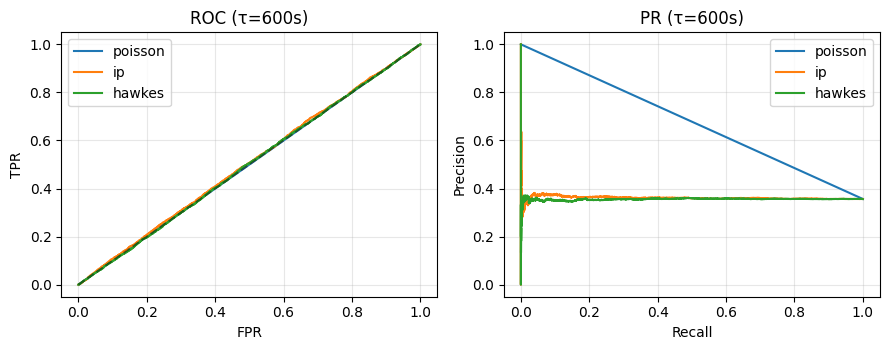

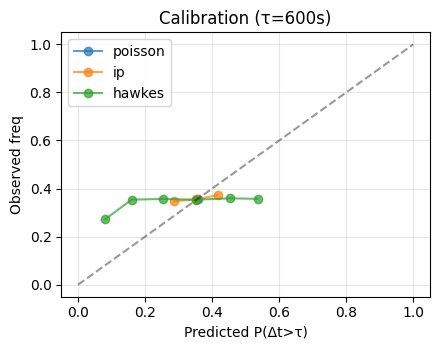

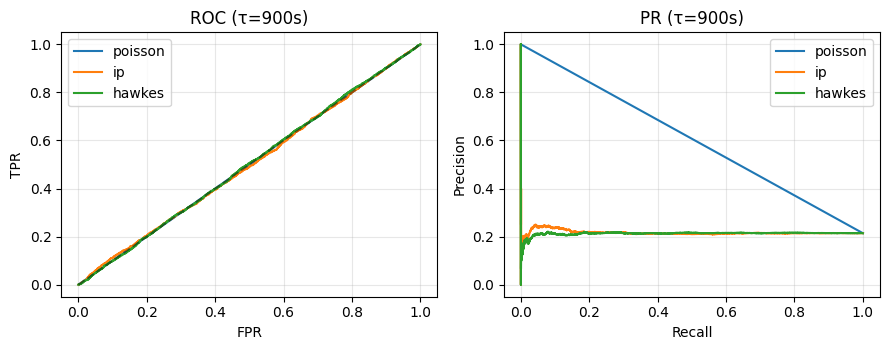

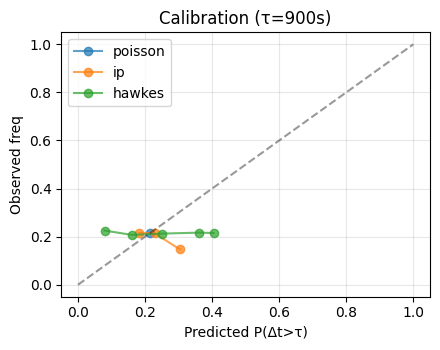

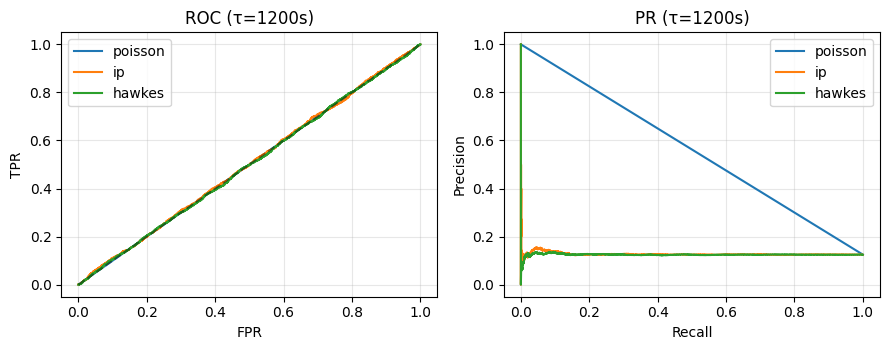

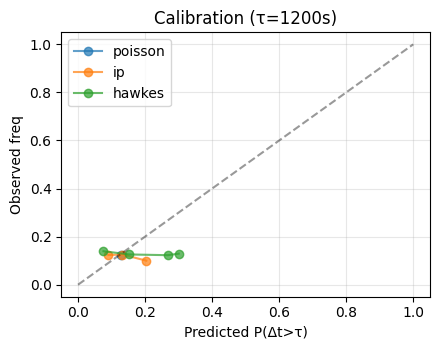


=== τ = 600s ===
poisson   ROC_AUC=0.500  PR_AUC=0.357  Brier=0.2294  LogLoss=0.651
ip        ROC_AUC=0.506  PR_AUC=0.361  Brier=0.2302  LogLoss=0.653
hawkes    ROC_AUC=0.501  PR_AUC=0.356  Brier=0.2496  LogLoss=0.696

=== τ = 900s ===
poisson   ROC_AUC=0.500  PR_AUC=0.214  Brier=0.1684  LogLoss=0.520
ip        ROC_AUC=0.500  PR_AUC=0.217  Brier=0.1692  LogLoss=0.522
hawkes    ROC_AUC=0.502  PR_AUC=0.213  Brier=0.1871  LogLoss=0.564

=== τ = 1200s ===
poisson   ROC_AUC=0.500  PR_AUC=0.125  Brier=0.1095  LogLoss=0.377
ip        ROC_AUC=0.503  PR_AUC=0.128  Brier=0.1100  LogLoss=0.379
hawkes    ROC_AUC=0.499  PR_AUC=0.125  Brier=0.1262  LogLoss=0.426


In [93]:
taus = (600, 900, 1200)   # 10, 15, 20 minutes
eval_results = evaluate_tail_models(times_data, X, id_pois=id_pois, id_ip=id_ip, id_hawkes=id_hawkes, taus=taus)

# Pretty print
for tau, sc in eval_results.items():
    print(f"\n=== τ = {tau}s ===")
    for name, m in sc.items():
        print(f"{name:8s}  ROC_AUC={m['ROC_AUC']:.3f}  PR_AUC={m['PR_AUC']:.3f}  "
              f"Brier={m['Brier']:.4f}  LogLoss={m['LogLoss']:.3f}")
